In [1]:
# External modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import importlib
import numpy as np
import os, sys
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../utils/'))

# Local modules
import get_oms_data
from get_oms_data import get_oms_api, get_oms_data, get_oms_response_attribute

import json_utils as jsonu
import plot_utils as pu

import mplhep as hep
hep.style.use("CMS")

import json_utils
from refruns_utils import get_reference_run as RRfetch
import refrank_utils as rrr
import oms_utils as omsu

In [2]:
# importlib.reload(get_oms_data)
importlib.reload(rrr)
# importlib.reload(omsu)

<module 'refrank_utils' from '/eos/home-i02/r/rcruzcan/SWAN_projects/RefRunRank/utils/refrank_utils.py'>

# Getting the Data
We start by instantiating the OMS API. The OMS API will be used to get Run and LS level data and will be the main source of information for the reference run ranking (RRR) system.

In [21]:
omsapi = get_oms_api()

In [4]:
# These are the features that will be fetched from OMS
# Run level attributes
run_attribs = [
    "run_number", #
    "init_lumi", #
    "recorded_lumi",
    "delivered_lumi",
    "energy",
    "end_lumi", #
    "hlt_physics_rate",
    "fill_number", # Neccesary for filtering NaNs
    "initial_prescale_index",
    "last_lumisection_number",
    "l1_rate",
    "hlt_physics_counter",
    "l1_hlt_mode",
    "duration"
]

# Lumisecion (LS) level attributes
ls_attribs = [
    "fill_number", # Neccesary for filtering NaNs
    "run_number",
    "lumisection_number",
    "pileup",
    "delivered_lumi",
    "recorded_lumi",
    "init_lumi",
    "end_lumi",
]

In [5]:
# Using the API, you can check all of the available features
run_query = rrr.makeDF(get_oms_data(omsapi, "runs", 316201, limit_entries=1))
print("All available run level features:\n")
run_query.info()

https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][EQ]=316201&page[offset]=0&page[limit]=1
https://vocms0185.cern.ch/agg/api/v1/runs/?filter[run_number][EQ]=316201&page[offset]=0&page[limit]=1
All available run level features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   components                 1 non-null      object 
 1   l1_hlt_mode_stripped       1 non-null      object 
 2   l1_key                     1 non-null      object 
 3   duration                   1 non-null      int64  
 4   b_field                    1 non-null      float64
 5   tier0_transfer             1 non-null      bool   
 6   l1_triggers_counter        1 non-null      int64  
 7   hlt_physics_throughput     1 non-null      float64
 8   init_lumi                  1 non-null      float64
 9   era                        1 non-null  

In [6]:
run_query

components l1_hlt_mode_stripped  \
0  [CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...  collisions2018/v104   

                      l1_key  duration  b_field  tier0_transfer  \
0  l1_trg_collisions2018/v20     11652    3.801            True   

   l1_triggers_counter  hlt_physics_throughput  init_lumi    era  ...  \
0            688298338                0.515921   1.080307  2018A  ...   

  fill_type_runtime                                   hlt_key  clock_type  \
0           PROTONS  /cdaq/physics/Run2018/2e34/v2.0.3/HLT/V1         LHC   

   last_lumisection_number    l1_rate                       l1_menu  \
0                      498  60138.625  L1Menu_Collisions2018_v1_0_0   

   run_number  stable_beam  beta_star_stop  hlt_physics_counter  
0      316201         True            30.0              9079675  

[1 rows x 43 columns]

In [7]:
# Using the API, you can check all of the available features
ls_query = rrr.makeDF(get_oms_data(omsapi, "lumisections", 316201, limit_entries=1))
print("All available LS level features:\n")
ls_query.info()

https://vocms0185.cern.ch/agg/api/v1/lumisections/?filter[run_number][EQ]=316201&page[offset]=0&page[limit]=1
https://vocms0185.cern.ch/agg/api/v1/lumisections/?filter[run_number][EQ]=316201&page[offset]=0&page[limit]=1
All available LS level features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   beam1_present                   1 non-null      bool   
 1   bpix_ready                      1 non-null      bool   
 2   ho_ready                        1 non-null      bool   
 3   dtp_ready                       1 non-null      bool   
 4   tecm_ready                      1 non-null      bool   
 5   delivered_lumi_per_lumisection  1 non-null      float64
 6   recorded_lumi_per_lumisection   1 non-null      float64
 7   castor_ready                    1 non-null      bool   
 8   init_lumi                     

## Loading data

In [31]:
# Run we wish to certify and for which we will find a correspond reference run
# newest_run = 326201
# oldest_run = 309000

# All 2018 runs
# newest_run = 327802
# oldest_run = 308241

# Almost all 2018 runs
newest_run = 326201
oldest_run = 308800 # Oldest run OMS is allowing me to get

# Range of runs of interest
run_range = (oldest_run, newest_run)
print("Run range: {}".format(run_range))
print("Potential total number of runs to load: {}".format(newest_run - oldest_run))

Run range: (308800, 326201)
Potential total number of runs to load: 17401


In [42]:
# Filters to apply to data fetched from OMS
run_filters = [
    {"attribute_name": "l1_hlt_mode", "value": "collisions", "operator": "LIKE"}, # Only collision runs
    {"attribute_name": "last_lumisection_number", "value": 500, "operator": "GE"}
]

In [43]:
run_df, ls_df = omsu.get_runs_lss(run_range, omsapi, run_attribs, ls_attribs, run_filters=run_filters)

https://vocms0185.cern.ch/agg/api/v1/runs/?fields=energy,l1_hlt_mode,end_lumi,init_lumi,recorded_lumi,hlt_physics_rate,last_lumisection_number,initial_prescale_index,duration,fill_number,hlt_physics_counter,delivered_lumi,l1_rate,run_number&filter[run_number][GE]=308800&filter[run_number][LE]=313799&filter[l1_hlt_mode][LIKE]=collisions&filter[last_lumisection_number][GE]=500&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?fields=energy,l1_hlt_mode,end_lumi,init_lumi,recorded_lumi,hlt_physics_rate,last_lumisection_number,initial_prescale_index,duration,fill_number,hlt_physics_counter,delivered_lumi,l1_rate,run_number&filter[run_number][GE]=308800&filter[run_number][LE]=313799&filter[l1_hlt_mode][LIKE]=collisions&filter[last_lumisection_number][GE]=500&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?fields=energy,l1_hlt_mode,end_lumi,init_lumi,recorded_lumi,hlt_physics_rate,last_lumisection_number,initial_prescale_index,duration,fill_

https://vocms0185.cern.ch/agg/api/v1/lumisections/?fields=end_lumi,pileup,init_lumi,lumisection_number,recorded_lumi,fill_number,delivered_lumi,run_number&filter[run_number][GE]=318800&filter[run_number][LE]=319799&page[offset]=0&page[limit]=100000
https://vocms0185.cern.ch/agg/api/v1/lumisections/?fields=end_lumi,pileup,init_lumi,lumisection_number,recorded_lumi,fill_number,delivered_lumi,run_number&filter[run_number][GE]=318800&filter[run_number][LE]=319799&page[offset]=0&page[limit]=100000
https://vocms0185.cern.ch/agg/api/v1/lumisections/?fields=end_lumi,pileup,init_lumi,lumisection_number,recorded_lumi,fill_number,delivered_lumi,run_number&filter[run_number][GE]=319800&filter[run_number][LE]=320799&page[offset]=0&page[limit]=100000
https://vocms0185.cern.ch/agg/api/v1/lumisections/?fields=end_lumi,pileup,init_lumi,lumisection_number,recorded_lumi,fill_number,delivered_lumi,run_number&filter[run_number][GE]=319800&filter[run_number][LE]=320799&page[offset]=0&page[limit]=100000
http

In [39]:
run_df["last_lumisection_number"].to_list()

[1474,
 1345,
 1641,
 4843,
 2697,
 1384,
 1642,
 1585,
 1730,
 1218,
 1732,
 896,
 1538,
 1864,
 909,
 1412,
 1512,
 1358,
 1978,
 4395,
 1229,
 1644,
 1722,
 1551,
 1655,
 1772,
 1808,
 1099,
 1809,
 1449,
 1095,
 1790,
 1600,
 841,
 857,
 1334,
 975,
 996,
 1093,
 1448,
 1347,
 1364,
 848,
 1757,
 1113,
 1127,
 1033,
 1186,
 1132,
 1106,
 931,
 1165,
 914,
 935,
 1649,
 2077,
 1197,
 1023,
 1224,
 1221,
 1463,
 1379,
 1953,
 981,
 1619,
 2209,
 1349,
 1845,
 852,
 1011,
 1151,
 1432,
 838,
 1836,
 939,
 1179,
 1966,
 1397,
 853,
 1504,
 974,
 2059,
 829,
 1399,
 1312,
 1336,
 869,
 943,
 1772,
 1170,
 1104,
 1803,
 1138,
 1743,
 2245,
 1807,
 1089,
 1463,
 3177,
 1527,
 1975,
 983,
 882,
 965,
 929,
 2117,
 844,
 901,
 943,
 1274,
 1076,
 1926,
 831,
 831,
 1013,
 1179,
 819,
 806,
 1758,
 934,
 962,
 934,
 2659,
 1475,
 1283,
 938,
 1888,
 2095,
 1180,
 1311,
 808,
 1448,
 871,
 961,
 1668,
 808,
 1253,
 884,
 1486,
 1823,
 884,
 884,
 1798,
 1143,
 1604,
 1205,
 1090,
 1514,
 1272

In [ ]:
# Optional: Save to parquet
# run_df.to_parquet('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/omsrundata_2018.parquet')
# ls_df.to_parquet('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/omslsdata_2018.parquet')

In [41]:
# Optional: Load from parquet
run_df = pd.read_parquet('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/omsrundata_2018.parquet')
ls_df = pd.read_parquet('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/omslsdata_2018.parquet')

In [42]:
# Quick check of the loaded runs and LSs
print("Number of runs loaded from OMS: {}".format(len(run_df)))
print("Number of lumisections loaded from OMS: {}".format(len(ls_df)))
print("Number of runs in the LS df: {}".format(len(ls_df["run_number"].unique())))

Number of runs loaded from OMS: 1117
Number of lumisections loaded from OMS: 975738
Number of runs in the LS df: 6000


<font color='green'> Why does `ls_df` have so many more runs that `run_df`? Reason: `run_df` has been pre-filtered, `ls_df` hasn't. </font>

In [43]:
# Optional
# To do all of the filtering steps at once, you can run this cell. 
# Note that it might not apply the exact same exact filtering as the cells below this one due to it having been updated or the parameters modified.
run_df, ls_df = rrr.filter_runs(run_df, ls_df, "json_TRK_PromptReco_2018Runs.json", "collisions2018")

In [23]:
rrr.filter_runs?

In [26]:
run_df

run_number  init_lumi  recorded_lumi  delivered_lumi  energy  end_lumi  \
41        314472   0.001623       0.009077        0.011048    6499  0.001572   
42        314473   0.001552        0.00427        0.006126    6499  0.001536   
43        314474   0.001525       0.004117        0.006015    6499  0.001509   
44        314475   0.001506       0.004101        0.005908    6499  0.001486   
45        314476   0.001466       0.003833        0.005467    6499   0.00146   
...          ...        ...            ...             ...     ...       ...   
1021      325168   1.331723       4.264391        7.692555    6499  1.313957   
1022      325169   1.314463       5.546852        9.097055    6499  1.289789   
1023      325170   1.290078     265.164055      275.800922    6499  0.739645   
1024      325172   0.739148      68.954437       72.939688    6499  0.556369   
1025      325175    0.54277       1.649281        1.787219    6499   0.53954   

      hlt_physics_rate  fill_number  initial_prescale_index  \
41            1649.849         6570                       9   
42            2900.216         6570                       3   
43              3086.0         6570                       3   
44            2885.129         6570                       3   
45            2977.611         6570                       3   
...                ...          ...                     ...   
1021            968.83         7334                       5   
1022           982.252         7334                       5   
1023            910.48         7334                       5   
1024           632.345         7334                       0   
1025           101.562         7334                       0   

      last_lumisection_number    l1_rate  hlt_physics_counter     l1_hlt_mode  \
41                         85   36146.52              3230527  collisions2018   
42                         13   39206.13               878868  collisions2018   
43                         12  41741.863               863231  collisions2018   
44                         13   39028.61               874296  collisions2018   
45                         12   40268.25               832912  collisions2018   
...                       ...        ...                  ...             ...   
1021                       21   70897.14               406509  collisions2018   
1022                       23   72009.18               526624  collisions2018   
1023                     1205   79683.56             25553288  collisions2018   
1024                      485  62416.957              7016350  collisions2018   
1025                       35  17870.615                68656  collisions2018   

      duration  
41        2005  
42         333  
43         323  
44         335  
45         309  
...        ...  
1021       454  
1022       578  
1023     28105  
1024     11136  
1025       700  

[644 rows x 14 columns]

In [27]:
ls_df

run_number  lumisection_number  fill_number    pileup  delivered_lumi  \
220158      314472                   1         6570   0.00411             0.0   
220159      314472                   2         6570  0.003523             0.0   
220160      314472                   3         6570  0.014386             0.0   
220161      314472                   4         6570  0.010276             0.0   
220162      314472                   5         6570  0.012331             0.0   
...            ...                 ...          ...       ...             ...   
922642      325175                  51         7335       0.0             0.0   
922643      325175                  52         7335       0.0             0.0   
922644      325175                  53         7335       0.0             0.0   
922645      325175                  54         7335       0.0             0.0   
922646      325175                  55         7335       0.0             0.0   

        recorded_lumi  init_lumi  end_lumi  is_good  
220158            0.0        0.0       0.0     True  
220159            0.0        0.0       0.0     True  
220160            0.0        0.0       0.0     True  
220161            0.0        0.0       0.0     True  
220162            0.0        0.0       0.0     True  
...               ...        ...       ...      ...  
922642            0.0        0.0       0.0     True  
922643            0.0        0.0       0.0     True  
922644            0.0        0.0       0.0     True  
922645            0.0        0.0       0.0     True  
922646            0.0        0.0       0.0     True  

[278974 rows x 9 columns]

## Filtering out NaN values


Some of the rows has `fill_number = NaN`. This is problematic, so we will segment the rows into those that have this problem (`run_df_NaN`), and the rest (`run_df`). We also add `Fill Location` column and make the `run_number` column into an index column.

<font color='red'> INVESTIGATE WHY THESE RUNS/LSs HAVE NaN VALUES. FIGURE WHERE THESE LSs TEND TO HAPPEN (START OR END OF THE RUN). </font>

In [5]:
# Filter out runs that have NaN in fill number
run_df, run_df_NaN = rrr.has_fill(run_df)
print(
    '''
    Runs kept in run dataframe: {}
    Runs filtered out: {}
    Lowest run # kept: {}
    Highest run # kept: {}
    '''.format(
        len(run_df['run_number'].unique()), 
        len(run_df_NaN['run_number'].unique()),
        run_df['run_number'].min(),
        run_df['run_number'].max())
)

run_df = run_df.convert_dtypes()

# run_df = rrr.add_loc_wrt_fill(run_df)
run_df.set_index(['run_number'], inplace=True)
run_df.sort_index(level=['run_number'], inplace=True)
# run_df.reset_index(inplace=True)
run_df.fillna(0, inplace=True)


    Runs kept in run dataframe: 1075
    Runs filtered out: 42
    Lowest run # kept: 313605
    Highest run # kept: 326190
    


In [6]:
# Filter out LSs that have NaN values
ls_df, lsNaN_df = rrr.has_fill(ls_df)
print(
    '''
    Number of runs in LSs df: {}
    Runs filtered out: {}
    Lowest run # kept: {}
    Highest run # kept: {}
    '''.format(
        len(ls_df['run_number'].unique()),   
        len(lsNaN_df['run_number'].unique()),
        ls_df['run_number'].min(),
        ls_df['run_number'].max()
    )
)

ls_df = ls_df.convert_dtypes()

# ls_df = rrr.add_loc_wrt_fill(ls_df)
ls_df.set_index(['run_number', 'lumisection_number'], inplace=True)
ls_df.sort_index(level=['run_number', 'lumisection_number'], inplace=True)
# ls_df.reset_index(inplace=True)
ls_df.fillna(0, inplace=True)


    Number of runs in LSs df: 5926
    Runs filtered out: 74
    Lowest run # kept: 309026
    Highest run # kept: 326199
    


## Keeping only good runs
Note: It might be neccesary to generate a new golden JSON in RR depending on the range of runs chosen for ranking.

In [11]:
# Relevant golden jsons available in the json directory
golden_files = [
    "json_GOLDEN_2017.json", 
    "json_GOLDEN_2018.json",
    "json_GOLDEN_RRRdev.json",
    "json_TRK_PromptReco_314324to316201.json",
    "json_TRK_PromptReco_2018Runs.json"
]

Generated golden JSON such as `json_GOLDEN_RRRdev.json` made in RR using input similar to:
```json
{
  "and": [
    {">=": [{"var": "run.oms.run_number"}, 315190]},
    {"<=": [{"var": "run.oms.run_number"}, 316201]},
    {"==": [{"var": "lumisection.rr.tracker-pixel"}, "GOOD"]},
    {"==": [{"var": "lumisection.rr.tracker-strip"}, "GOOD"]},
    {"==": [{"var": "lumisection.rr.tracker-track"}, "GOOD"]}
  ]
}
```


In [221]:
run_df.reset_index(inplace=True)
ls_df.reset_index(inplace=True)

In [222]:
# Using golden json to know which LSs are bad and which ones are good
ls_df['is_good'] = json_utils.injson(
    np.array(ls_df['run_number']), 
    np.array(ls_df['lumisection_number']), 
    '/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/'+golden_files[4]
)

# Computing "run quality" metric
quality_score = ls_df.groupby("run_number")["is_good"].mean()

# Identify runs with quality < 0.75 as bad runs
bad_runs = quality_score[quality_score < 0.75].index.tolist()

# Classifying run as good or bad depending on their quality score

runbad_df = run_df[run_df['run_number'].isin(bad_runs)]
run_df = run_df[~run_df['run_number'].isin(bad_runs)]

lsbad_df = ls_df[ls_df['run_number'].isin(bad_runs)]
ls_df = ls_df[~ls_df['run_number'].isin(bad_runs)]

In [223]:
print(
    '''
        Number of good collision LSs: {}
        Number of bad collisions LSs: {}
        Number of runs in good df: {}
        Number of runs in bad df: {}
    '''.format(len(ls_df), len(lsbad_df), len(run_df), len(runbad_df))
)



        Number of good collision LSs: 443810
        Number of bad collisions LSs: 528082
        Number of runs in good df: 677
        Number of runs in bad df: 398
    


## Keeping only `collision2018` runs
(Note: The final filtering for the run type of interest is done here so that this notebook can be copied and re-used more easily for other types of runs like cosmics)

In [225]:
print("Types of runs in our data: ")
print(run_df["l1_hlt_mode"].unique().tolist())

Types of runs in our data: 
['collisions2018', 'collisions2018-l1menu-validation', 'collisions2018-hltmenu-validation', 'collisions2018_kalman_validation']


In [226]:
# For now, we are only interested in collision2018 runs, so we discard the rest.
run_notcoll2018_df = run_df[run_df["l1_hlt_mode"] != "collisions2018"]
run_df = run_df[run_df["l1_hlt_mode"] == "collisions2018"]

coll_runs = np.array(run_df["run_number"])
ls_notcoll2018_df = ls_df[~ls_df["run_number"].isin(coll_runs)]
ls_df = ls_df[ls_df["run_number"].isin(coll_runs)]

## Keeping only runs that appear in both dataframes

In [227]:
# Checking which runs appear in one dataframe, but not the other, and dropping them from both dataframes.

rundf_runs = np.array(run_df["run_number"])
lsdf_runs = np.array(ls_df["run_number"])

# Finding symmetric different
missing_runs = np.setxor1d(rundf_runs, lsdf_runs)

print(
    '''
    List of runs which are in one of the dataframes, but not the other (and viceversa): \n    {}
    '''.format(missing_runs)
)

# Removing runs that are not in both dataframes
run_df = run_df[~run_df["run_number"].isin(missing_runs)]
ls_df = ls_df[~ls_df["run_number"].isin(missing_runs)]


    List of runs which are in one of the dataframes, but not the other (and viceversa): 
    [314749 318871 320915 321391 321399 323489 324312 324393 325166 325341]
    


In [228]:
# Sanity check that the run filtering step worked
rundf_runs = np.array(run_df["run_number"])
lsdf_runs = np.array(ls_df["run_number"])

# Finding symmetric different
missing_runs = np.setxor1d(rundf_runs, lsdf_runs)

print(
    '''
    List of runs which are in one of the dataframes, but not the other (and viceversa): \n    {}
    '''.format(missing_runs)
)


    List of runs which are in one of the dataframes, but not the other (and viceversa): 
    []
    


In [229]:
print(
    '''
    Number of runs in the run dataframe: {}
    Number of runs in the lumisection dataframe: {}
    Are the runs contained in these dataframes exactly the same?: {}
    '''.format(
        len(run_df),
        len(ls_df["run_number"].unique()),
        np.array_equal(run_df["run_number"], ls_df["run_number"].unique())
    )
)


    Number of runs in the run dataframe: 644
    Number of runs in the lumisection dataframe: 644
    Are the runs contained in these dataframes exactly the same?: True
    


# Data Exploration

We create some plots to better understand how this data looks like

In [28]:
lumi_info = ls_df[['run_number',
                           'init_lumi', 
                           'end_lumi',
                           'pileup',
                           'recorded_lumi', 
                           'delivered_lumi',
                           'lumisection_number',]]

In [29]:
def plot_lumis(run_begin, run_end, lumi_info, run_labels=True):
    """
    Plotting init_lumi, pileup, recorded_lumi and delivered_lumi for a couple of runs
    """

    lumi_info['run_lumisection'] = list(zip(lumi_info['run_number'], lumi_info['lumisection_number']))

    filtered_lumi_info = lumi_info[(lumi_info['run_number'] >= run_begin) & (lumi_info['run_number'] <= run_end)]

    fig, ax = plt.subplots(dpi=200)
    
    if run_labels:
        current_run = None
        for idx, (run, lumisection) in enumerate(filtered_lumi_info['run_lumisection']):
            if run != current_run:
                ax.axvline(x=idx, color='gray', linestyle='--', linewidth=0.5)  # Add a vertical line

                # Add a label for the run number
                if current_run is not None:  # Skip label for the very first line
                    label_x_position = idx - 1  # Adjust this to position the label
                    ax.text(label_x_position, 0.95, str(current_run), transform=ax.get_xaxis_transform(), 
                            horizontalalignment='right', verticalalignment='top', fontsize=6, color='gray', rotation='vertical')

                current_run = run
                
    features_to_plot = [
        'init_lumi', 
        'pileup', 
        'recorded_lumi', 
        'delivered_lumi'
    ]

    filtered_lumi_info.plot(x='run_lumisection', y=features_to_plot, secondary_y='pileup', ax=ax, style="o", markersize=1)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_yscale('log')
    plt.title(f"Run {run_begin} to {run_end}")
    plt.show()

/tmp/ipykernel_698/2286011789.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lumi_info['run_lumisection'] = list(zip(lumi_info['run_number'], lumi_info['lumisection_number']))


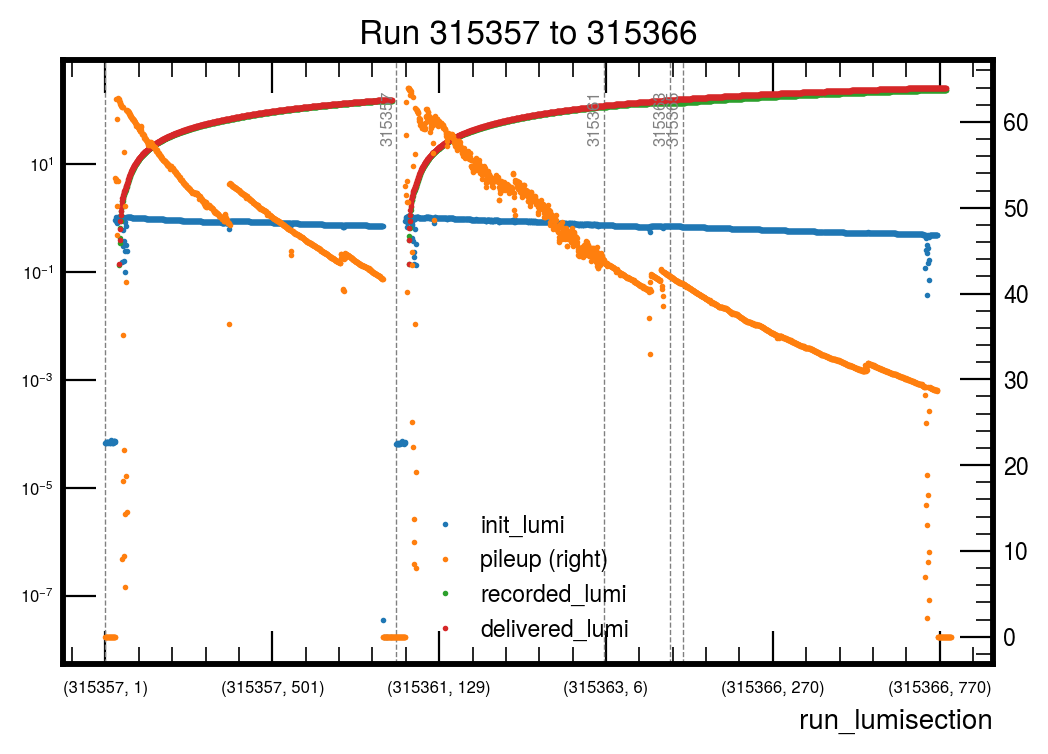

In [30]:
plot_lumis(315357, 315366, lumi_info)

/tmp/ipykernel_698/2286011789.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lumi_info['run_lumisection'] = list(zip(lumi_info['run_number'], lumi_info['lumisection_number']))


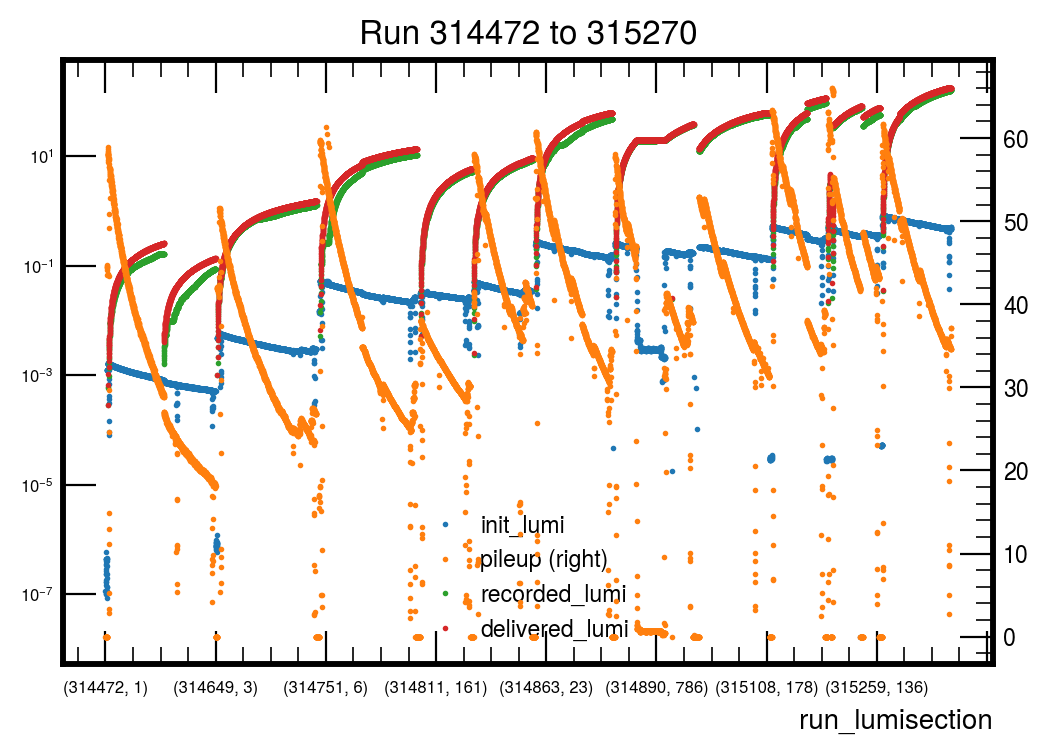

In [31]:
plot_lumis(lumi_info["run_number"].min(), 315270, lumi_info, run_labels=False)

# Reference Run Ranking Using PCA

In [44]:
# Turn off warnings for pandas
pd.options.mode.chained_assignment = None
importlib.reload(rrr)

<module 'refrank_utils' from '/eos/home-i02/r/rcruzcan/SWAN_projects/RefRunRank/utils/refrank_utils.py'>

In [45]:
# Run level attributes compatible with PCA
runfeaturelst = [
    "run_number", #
    "init_lumi", #
    "recorded_lumi",
    "energy",
    "end_lumi", #
    "hlt_physics_rate",
#     "fill_number",
#     "initial_prescale_index",
#     "last_lumisection_number",
    "l1_rate",
    "hlt_physics_counter",
]

# Lumisecion (LS) level attributes compatible with PCA
lsfeaturelst = [
    "run_number",
#     "fill_number",
    "lumisection_number",
    "pileup",
#     "delivered_lumi",
#     "recorded_lumi",
    "init_lumi",
    "end_lumi",
]

run_df = run_df[runfeaturelst]
ls_df = ls_df[lsfeaturelst]

## Additional features

In [46]:
# Computing change in total luminosity across the run
run_df = rrr.comp_delta_totallumi(run_df)

In [47]:
# Numerical LS level features of interest
lsfeaturelst = [
    'run_number', 
    'lumisection_number',
    'init_lumi', 
    'end_lumi', 
    'pileup'
]

In [48]:
# Computing the init_lumi, end_lumi and pileup std, mean, max and min over the run
names = ['init_lumi', 'end_lumi', 'pileup']
names = [name + suffix for suffix in ['_std', '_mean', "_max", "_min"] for name in names]

lsstats_dict = {}
for run in ls_df['run_number'].unique():
    runlsstats = ls_df[ls_df['run_number'] == run].describe()
    stds = runlsstats.loc['std'].to_list()[2:]
    means = runlsstats.loc['mean'].to_list()[2:]
    maxs = runlsstats.loc["max"].to_list()[2:]
    mins = runlsstats.loc["min"].to_list()[2:]
    lsstats_dict[run] = {name: stat for name, stat in zip(names, stds + means + maxs + mins)}    
    
# Constructing a lumisection dataframe to hold these features of interest.
ls_features = pd.DataFrame(lsstats_dict).T

In [49]:
features = pd.concat([run_df.set_index('run_number'), ls_features], axis=1).reset_index()
features.rename(columns = {'index':'run_number'}, inplace=True)
features

run_number  init_lumi  recorded_lumi  energy  end_lumi  hlt_physics_rate  \
0        314472   0.001623       0.009077    6499  0.001572          1649.849   
1        314473   0.001552        0.00427    6499  0.001536          2900.216   
2        314474   0.001525       0.004117    6499  0.001509            3086.0   
3        314475   0.001506       0.004101    6499  0.001486          2885.129   
4        314476   0.001466       0.003833    6499   0.00146          2977.611   
..          ...        ...            ...     ...       ...               ...   
639      325168   1.331723       4.264391    6499  1.313957            968.83   
640      325169   1.314463       5.546852    6499  1.289789           982.252   
641      325170   1.290078     265.164055    6499  0.739645            910.48   
642      325172   0.739148      68.954437    6499  0.556369           632.345   
643      325175    0.54277       1.649281    6499   0.53954           101.562   

       l1_rate  hlt_physics_counter  delta_totallumi  init_lumi_std  ...  \
0     36146.52              3230527        -0.000051      26.350121  ...   
1     39206.13               878868        -0.000015       0.315599  ...   
2    41741.863               863231        -0.000016       0.297206  ...   
3     39028.61               874296        -0.000019       0.410320  ...   
4     40268.25               832912        -0.000006       0.315032  ...   
..         ...                  ...              ...            ...  ...   
639   70897.14               406509        -0.017766       0.164968  ...   
640   72009.18               526624        -0.024674       0.204876  ...   
641   79683.56             25553288        -0.550433       4.337408  ...   
642  62416.957              7016350        -0.182779       1.449452  ...   
643  17870.615                68656         -0.00323       6.799432  ...   

     pileup_std  init_lumi_mean  end_lumi_mean  pileup_mean  init_lumi_max  \
0      0.000737       32.349674       0.000909     0.000927      58.975708   
1      0.000010       55.029805       0.001547     0.001546      55.568684   
2      0.000009       54.064429       0.001520     0.001519      54.652905   
3      0.000013       53.115828       0.001493     0.001491      53.811634   
4      0.000009       52.169618       0.001467     0.001466      52.948135   
..          ...             ...            ...          ...            ...   
639    0.005594       36.951367       1.320900     1.320236      37.254112   
640    0.007208       36.412215       1.301627     1.300841      36.771286   
641    0.154940       27.345997       0.977537     0.977083      36.089138   
642    0.051738       17.873600       0.638927     0.638562      20.680555   
643    0.237672        4.125751       0.147483     0.137615      15.183657   

     end_lumi_max  pileup_max  init_lumi_min  end_lumi_min    pileup_min  
0        0.001658    0.001658       0.002936  8.254200e-08  8.254200e-08  
1        0.001562    0.001562      54.413429  1.529781e-03  1.525110e-03  
2        0.001537    0.001537      53.526672  1.504851e-03  1.504851e-03  
3        0.001513    0.001513      52.436508  1.474202e-03  1.465810e-03  
4        0.001489    0.001489      51.753624  1.455003e-03  1.454352e-03  
..            ...         ...            ...           ...           ...  
639      1.331723    1.330605      36.685764  1.311406e+00  1.311406e+00  
640      1.314463    1.312673      36.081058  1.289789e+00  1.289789e+00  
641      1.290078    1.288871      19.837626  7.091354e-01  7.091354e-01  
642      0.739268    0.739268      15.548651  5.558175e-01  5.558175e-01  
643      0.542770    0.541887       0.000000  0.000000e+00  0.000000e+00  

[644 rows x 21 columns]

## Weights & Correlations
We can determine the weight each feature has relative to each other (if we interpret the coefficients of the first PC as a weight) as well as plot each feature against the others to get a sense of how correlated they all are.

NOTE: `rrr.get_weights` needs to be run with matplotlib version <= 3.7 if using `plot=True`

In [50]:
print("Available features")
features.info()

Available features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   run_number           644 non-null    Int64  
 1   init_lumi            644 non-null    Float64
 2   recorded_lumi        644 non-null    Float64
 3   energy               644 non-null    Int64  
 4   end_lumi             644 non-null    Float64
 5   hlt_physics_rate     644 non-null    Float64
 6   l1_rate              644 non-null    Float64
 7   hlt_physics_counter  644 non-null    Int64  
 8   delta_totallumi      644 non-null    Float64
 9   init_lumi_std        644 non-null    float64
 10  end_lumi_std         644 non-null    float64
 11  pileup_std           644 non-null    float64
 12  init_lumi_mean       644 non-null    float64
 13  end_lumi_mean        644 non-null    float64
 14  pileup_mean          644 non-null    float64
 15  init_lumi_max        

In [51]:
# Get the weights by taking the first principal component
features_weights = rrr.get_weights(features, plot=True)

In [52]:
# Getting weights for each of the features
ftrweights_dict = {feature: round(weight, 4) for feature, weight in zip(features.columns.to_list(), features_weights)}
ftrweights_df = pd.DataFrame(list(ftrweights_dict.items()), columns=["Feature", "Weight"]).sort_values("Weight", ascending=False).reset_index(drop=True)
ftrweights_df

Feature  Weight
0            pileup_max  0.1186
1          end_lumi_max  0.1186
2             init_lumi  0.1154
3           pileup_mean  0.0930
4         end_lumi_mean  0.0929
5              end_lumi  0.0741
6          end_lumi_std  0.0643
7            pileup_std  0.0642
8         init_lumi_std  0.0387
9         recorded_lumi  0.0366
10           run_number  0.0352
11              l1_rate  0.0313
12      delta_totallumi  0.0305
13        init_lumi_max  0.0296
14        init_lumi_min  0.0281
15     hlt_physics_rate  0.0142
16  hlt_physics_counter  0.0093
17       init_lumi_mean  0.0022
18               energy  0.0021
19         end_lumi_min  0.0007
20           pileup_min  0.0007

In [53]:
# Making correlation matrix
corr_matrix = features.corr()
corr_matrix

run_number  init_lumi  recorded_lumi    energy  end_lumi  \
run_number             1.000000   0.507770       0.230180 -0.110651  0.485467   
init_lumi              0.507770   1.000000       0.501090  0.115669  0.803129   
recorded_lumi          0.230180   0.501090       1.000000  0.051268  0.081307   
energy                -0.110651   0.115669       0.051268  1.000000  0.103281   
end_lumi               0.485467   0.803129       0.081307  0.103281  1.000000   
hlt_physics_rate      -0.334736  -0.335386      -0.140582  0.003094 -0.304078   
l1_rate                0.499487   0.476348       0.422032  0.130716  0.339003   
hlt_physics_counter    0.097114   0.215070       0.662461 -0.026797 -0.078982   
delta_totallumi       -0.147802  -0.511644      -0.719477 -0.044208  0.100999   
init_lumi_std          0.131928   0.409951       0.164112  0.068851  0.287116   
end_lumi_std           0.262044   0.605055       0.264947  0.063888  0.455191   
pileup_std             0.262205   0.603786       0.268039  0.064002  0.450758   
init_lumi_mean        -0.219882   0.166538      -0.022697  0.213258  0.223277   
end_lumi_mean          0.486309   0.904502       0.365353  0.113948  0.851746   
pileup_mean            0.485383   0.903987       0.363797  0.113773  0.852535   
init_lumi_max         -0.099088   0.445848       0.261991  0.238158  0.326376   
end_lumi_max           0.499722   0.979097       0.505543  0.116657  0.820667   
pileup_max             0.498908   0.978958       0.505974  0.116532  0.820316   
init_lumi_min         -0.272103  -0.332180      -0.405061  0.058781 -0.128903   
end_lumi_min           0.196561   0.231058      -0.185293  0.044253  0.397991   
pileup_min             0.196753   0.231322      -0.185354  0.044220  0.398509   

                     hlt_physics_rate   l1_rate  hlt_physics_counter  \
run_number                  -0.334736  0.499487             0.097114   
init_lumi                   -0.335386  0.476348             0.215070   
recorded_lumi               -0.140582  0.422032             0.662461   
energy                       0.003094  0.130716            -0.026797   
end_lumi                    -0.304078  0.339003            -0.078982   
hlt_physics_rate             1.000000  0.052949             0.207864   
l1_rate                      0.052949  1.000000             0.216198   
hlt_physics_counter          0.207864  0.216198             1.000000   
delta_totallumi              0.121531 -0.306546            -0.473026   
init_lumi_std               -0.134489  0.052589             0.166553   
end_lumi_std                -0.216251  0.175683             0.119623   
pileup_std                  -0.216630  0.176806             0.121741   
init_lumi_mean               0.224895  0.006033            -0.042056   
end_lumi_mean               -0.305988  0.473084             0.112089   
pileup_mean                 -0.305760  0.470017             0.111240   
init_lumi_max                0.116498  0.055394             0.223146   
end_lumi_max                -0.339261  0.461484             0.216403   
pileup_max                  -0.338528  0.460748             0.216903   
init_lumi_min                0.219329 -0.209894            -0.337656   
end_lumi_min                -0.142168  0.103487            -0.205354   
pileup_min                  -0.141801  0.103765            -0.205372   

                     delta_totallumi  init_lumi_std  ...  pileup_std  \
run_number                 -0.147802       0.131928  ...    0.262205   
init_lumi                  -0.511644       0.409951  ...    0.603786   
recorded_lumi              -0.719477       0.164112  ...    0.268039   
energy                     -0.044208       0.068851  ...    0.064002   
end_lumi                    0.100999       0.287116  ...    0.450758   
hlt_physics_rate            0.121531      -0.134489  ...   -0.216630   
l1_rate                    -0.306546       0.052589  ...    0.176806   
hlt_physics_counter        -0.473026       0.166553  ...    0.121741   
delta

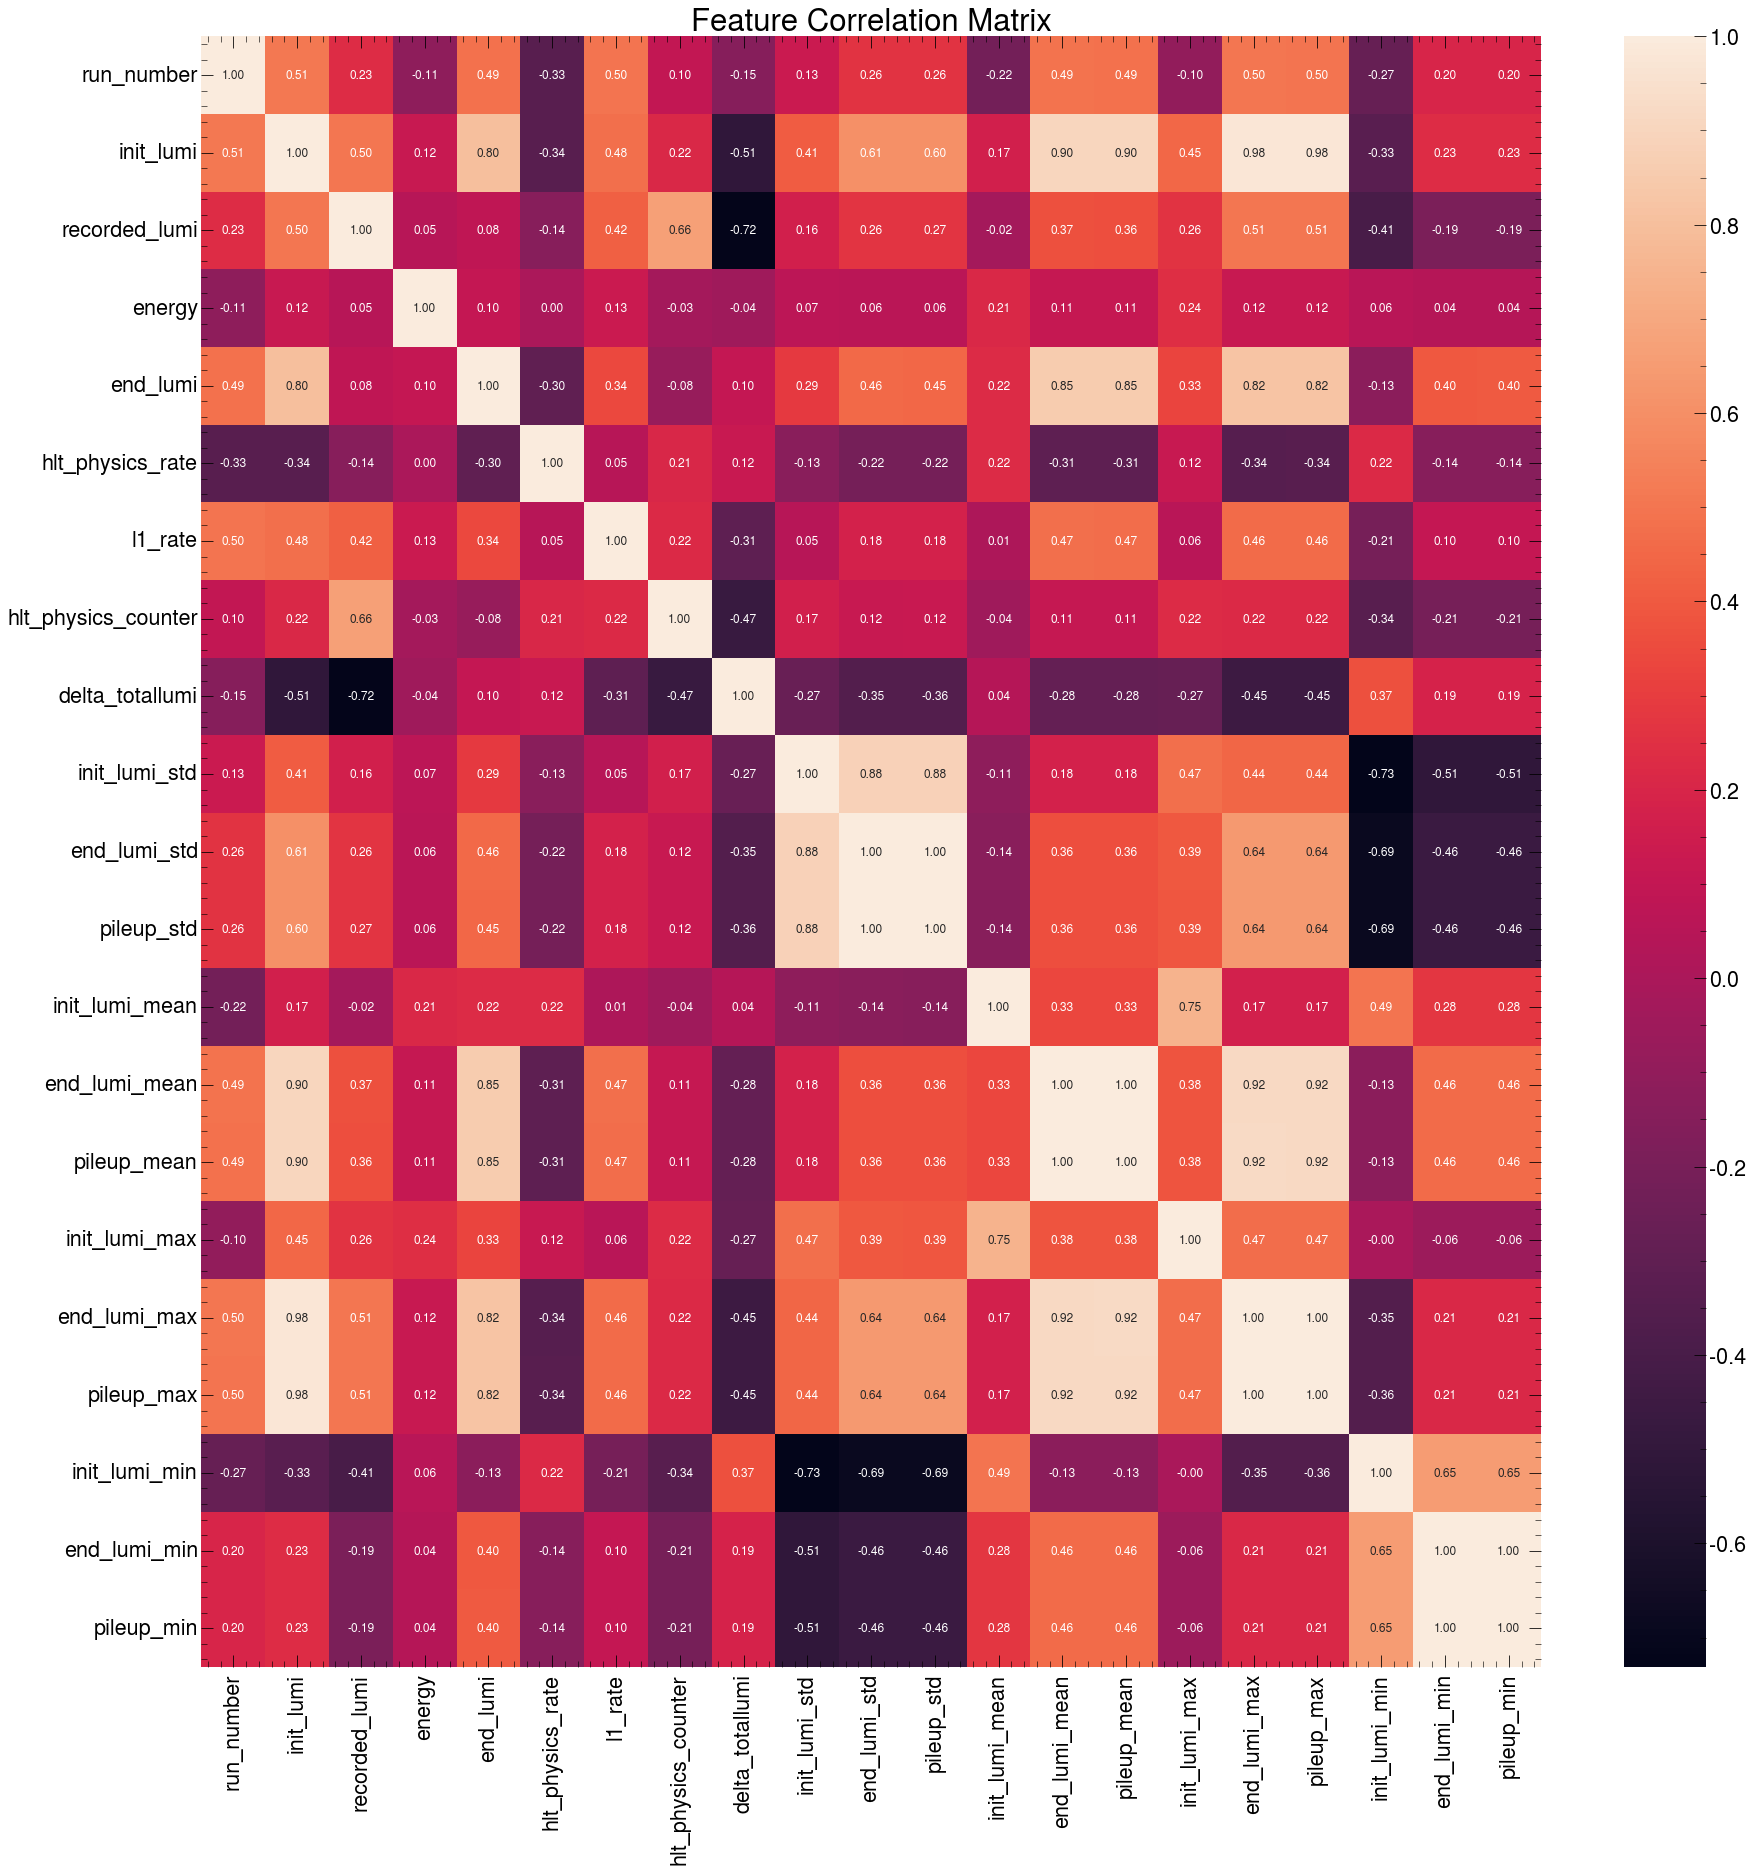

In [54]:
# Plotting correlation matrix
plt.figure(figsize=(30, 30))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidth=0.5)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", annot_kws={"size": 12})
plt.title("Feature Correlation Matrix")
plt.show()

In [55]:
# Extracting features with low correlation only
# Higher threshold means we accept features that have higher correlation with eachother
threshold = 0.6

to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            to_drop.add(corr_matrix.columns[j])
to_drop = list(to_drop)

In [56]:
features_lowcorr = features[features.columns[~features.columns.isin(to_drop)]]

In [57]:
features_lowcorr

run_number  init_lumi  recorded_lumi  energy  hlt_physics_rate  \
0        314472   0.001623       0.009077    6499          1649.849   
1        314473   0.001552        0.00427    6499          2900.216   
2        314474   0.001525       0.004117    6499            3086.0   
3        314475   0.001506       0.004101    6499          2885.129   
4        314476   0.001466       0.003833    6499          2977.611   
..          ...        ...            ...     ...               ...   
639      325168   1.331723       4.264391    6499            968.83   
640      325169   1.314463       5.546852    6499           982.252   
641      325170   1.290078     265.164055    6499            910.48   
642      325172   0.739148      68.954437    6499           632.345   
643      325175    0.54277       1.649281    6499           101.562   

       l1_rate  init_lumi_std  init_lumi_mean  
0     36146.52      26.350121       32.349674  
1     39206.13       0.315599       55.029805  
2    41741.863       0.297206       54.064429  
3     39028.61       0.410320       53.115828  
4     40268.25       0.315032       52.169618  
..         ...            ...             ...  
639   70897.14       0.164968       36.951367  
640   72009.18       0.204876       36.412215  
641   79683.56       4.337408       27.345997  
642  62416.957       1.449452       17.873600  
643  17870.615       6.799432        4.125751  

[644 rows x 8 columns]

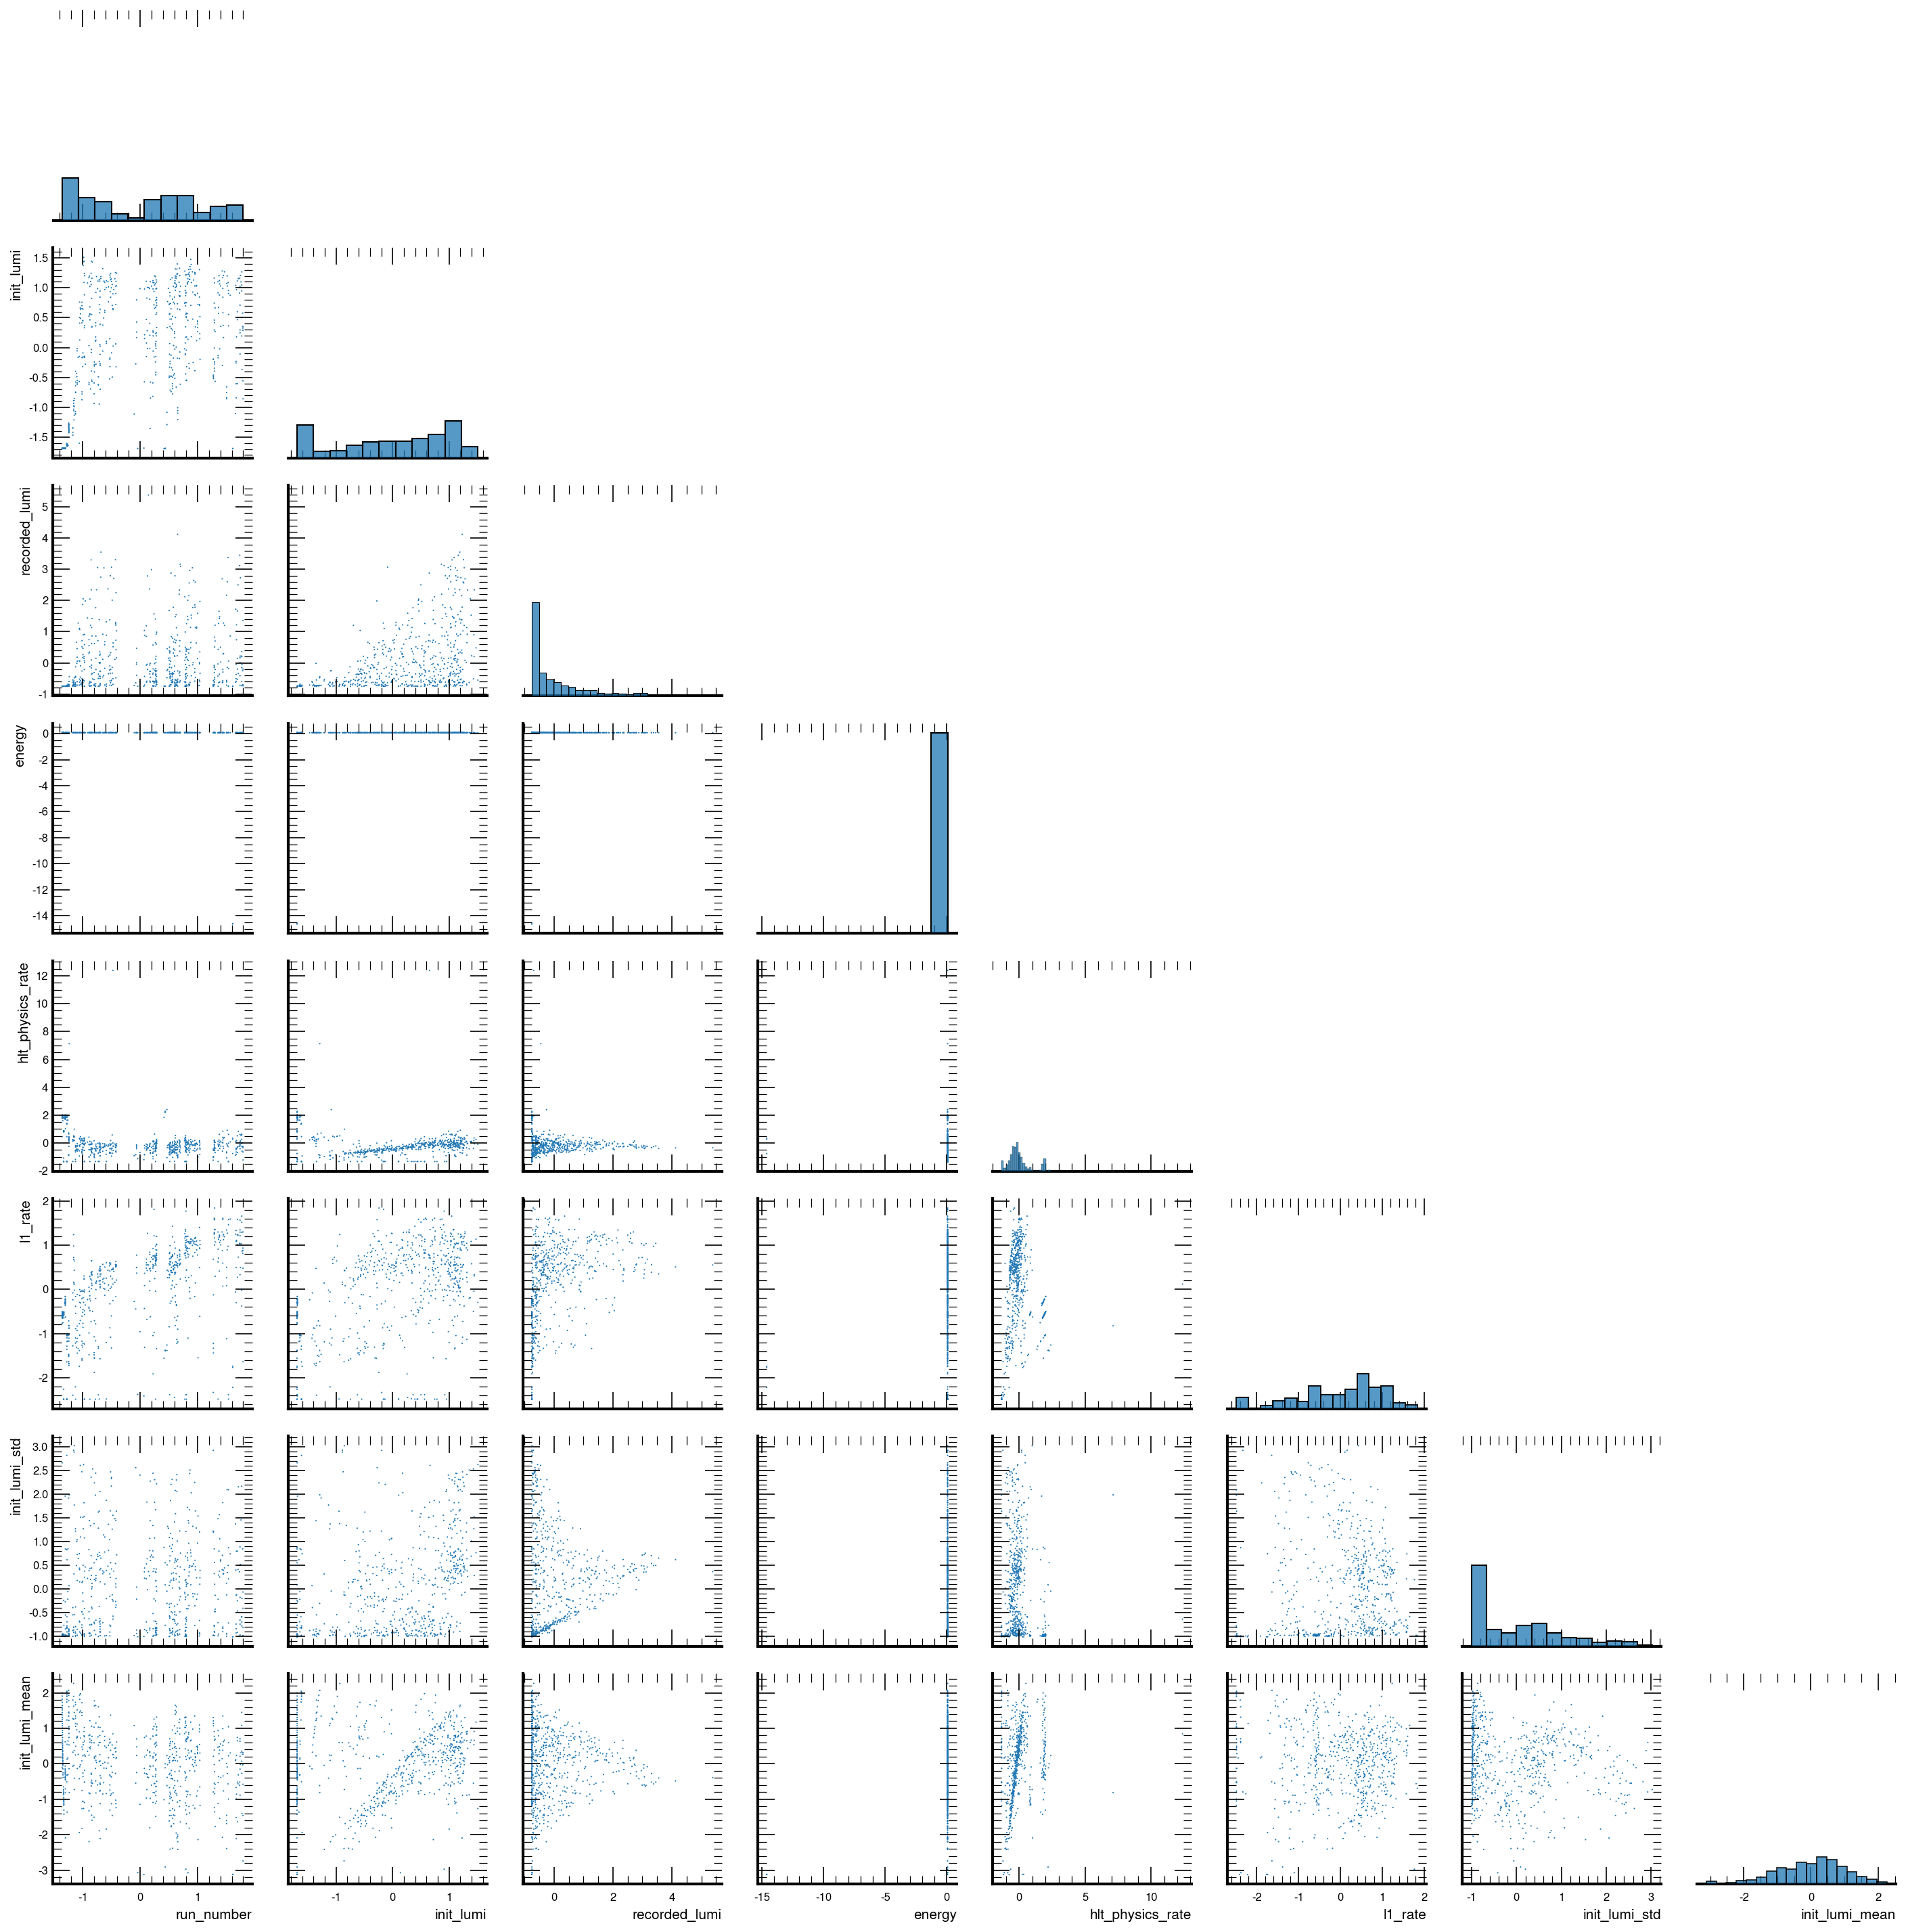

In [58]:
# Getting weights of only features that are not highly correlated
featureslowcorr_weights = rrr.get_weights(features_lowcorr, plot=True)

In [59]:
# Checking the weights for each of these low correlation features
# Getting weights for each of the features
ftrweightslowcorr_dict = {feature: round(weight, 4) for feature, weight in zip(features_lowcorr.columns.to_list(), featureslowcorr_weights)}
ftrweightslowcorr_df = pd.DataFrame(list(ftrweightslowcorr_dict.items()), columns=["Feature", "Weight"]).sort_values("Weight", ascending=False).reset_index(drop=True)
ftrweightslowcorr_df

Feature  Weight
0         init_lumi  0.2888
1        run_number  0.2090
2           l1_rate  0.1820
3     recorded_lumi  0.1689
4  hlt_physics_rate  0.0720
5     init_lumi_std  0.0718
6    init_lumi_mean  0.0038
7            energy  0.0036

# Ranking With PCA

## With `run_number`

In [60]:
# Extracting name of features that have high weights
ftrs_to_use = ftrweightslowcorr_df["Feature"][:6].to_list()

In [61]:
# Keeping only feaetures with high weight and low correlation between each other
pcafeats = features_lowcorr[ftrs_to_use]
pcafeats

init_lumi  run_number    l1_rate  recorded_lumi  hlt_physics_rate  \
0     0.001623      314472   36146.52       0.009077          1649.849   
1     0.001552      314473   39206.13        0.00427          2900.216   
2     0.001525      314474  41741.863       0.004117            3086.0   
3     0.001506      314475   39028.61       0.004101          2885.129   
4     0.001466      314476   40268.25       0.003833          2977.611   
..         ...         ...        ...            ...               ...   
639   1.331723      325168   70897.14       4.264391            968.83   
640   1.314463      325169   72009.18       5.546852           982.252   
641   1.290078      325170   79683.56     265.164055            910.48   
642   0.739148      325172  62416.957      68.954437           632.345   
643    0.54277      325175  17870.615       1.649281           101.562   

     init_lumi_std  
0        26.350121  
1         0.315599  
2         0.297206  
3         0.410320  
4         0.315032  
..             ...  
639       0.164968  
640       0.204876  
641       4.337408  
642       1.449452  
643       6.799432  

[644 rows x 6 columns]

In [62]:
# Reformatting df for use in ranking
pcafeats["run"] = pcafeats["run_number"].astype(int)
pcafeats.set_index("run", inplace=True)
pcafeats.tail()

init_lumi  run_number    l1_rate  recorded_lumi  hlt_physics_rate  \
run                                                                         
325168   1.331723      325168   70897.14       4.264391            968.83   
325169   1.314463      325169   72009.18       5.546852           982.252   
325170   1.290078      325170   79683.56     265.164055            910.48   
325172   0.739148      325172  62416.957      68.954437           632.345   
325175    0.54277      325175  17870.615       1.649281           101.562   

        init_lumi_std  
run                    
325168       0.164968  
325169       0.204876  
325170       4.337408  
325172       1.449452  
325175       6.799432

In [63]:
# Initial test that ranking system actually ranks
target = 316082
targetRR = RRfetch(target, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/json_allRunsRefRuns.json')
rankings = rrr.refrank_pca(pcafeats.loc[:target], target, n_components = 2)
print('Ranking of RR used: ', rankings.index[rankings['run']==targetRR][0])
rankings = pd.merge(rankings.set_index("run"), pcafeats, left_index=True, right_index=True, how='left').reset_index()
rankings.head(10)

Ranking of RR used:  8


run      dist       PC1       PC2  init_lumi  run_number    l1_rate  \
0  316082  0.000000  3.922407  1.192653   1.881687      316082   51408.74   
1  315800  0.262000  3.660544  1.201102   1.885026      315800  51127.906   
2  315721  0.276939  3.966026  1.466136   2.040181      315721  51465.383   
3  315973  0.300329  4.163683  1.013815   1.807007      315973  47469.637   
4  315840  0.406111  3.755994  0.822204    0.92115      315840  44897.473   
5  316058  0.458234  3.512277  1.397035   1.863196      316058  53345.934   
6  315689  0.540920  3.822394  0.661059   1.398032      315689   41360.71   
7  315741  0.569253  3.372108  1.046983   2.086029      315741  46130.504   
8  315713  0.697603  4.606687  1.328340   1.998048      315713  48360.707   
9  315770  0.766020  3.519152  1.843938   2.042558      315770  58702.617   

   recorded_lumi  hlt_physics_rate  init_lumi_std  
0     137.502563          1142.772      17.602240  
1     208.878219          1365.015       9.956593  
2     207.075109          1395.164      16.372513  
3      275.23075          1289.331       8.853810  
4     343.773094           1217.83      10.582414  
5     133.127375          1611.583      13.219033  
6      329.92225          1219.599       8.429840  
7      24.312406          1137.968      26.084098  
8     352.296906          1323.928      10.834837  
9     119.330164          1556.362      18.243862

In [64]:
from numpy import trapz

def test_ranking(features, comparison_num=60, n_components=1, print_stats=True, dpi=200):
    # Testing over many target runs to obtain better idea of performance
    RRranks = []
    results = {}

    # Loop over some of the runs that are available
    for targ in list(features.reset_index()['run'].unique())[comparison_num+1:]:
        # Get reference run
        targetRR = RRfetch(targ, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/json_allRunsRefRuns.json')

        rankings = rrr.refrank_pca(features.loc[:targ].iloc[-comparison_num:], targ, n_components=n_components)

        # In case there are any target runs for which the number of candidate runs is 0
        if rankings is None:
            pass

        # Get the rank the actual reference got
        try: 
            actualrefrank = rankings.index[rankings['run']==targetRR][0]
            RRranks.append(actualrefrank)
            results[targ] = {'ActualRef': targetRR, 'ActualRefRank': actualrefrank}
        except IndexError: # Error due to actual reference run not being available
            continue


    results = pd.DataFrame(results).T
    
    if print_stats:
#         print(results['ActualRefRank'].describe())
        # Lower mean rank indicates better performance
        print("Mean rank of actual RR: {}".format(np.mean(RRranks)))
        # Less sensitive to outliers than mean rank, better idea of central tendency
        print("Median rank of actual RR: {}".format(np.median(RRranks)))
        # Measures how often actual RR appears withing top-k ranks
        print("Top-k accuracy (k=10): {}".format(sum(rank < 10 for rank in RRranks) / len(RRranks)))
        # Stat measure for evaluating processes that produce a list of possible responses to a sample of queries, ordered by probability of correctness. 
        # Its the average of the reciprocal ranks of results for a sample of queries
        print("Mean reciprocal rank: {}".format(np.mean([1.0 / (rank + 1) for rank in RRranks])))
        
        # Making CDF plot
        RRranks_sorted = np.sort(RRranks)
        
        x_normalized = RRranks_sorted / RRranks_sorted.max()
        cdf = np.arange(1, len(RRranks_sorted) + 1) / len(RRranks_sorted)
        
        auc = trapz(cdf, x_normalized)
        
        plt.plot(RRranks_sorted, cdf)
        plt.xlabel("Rank of Actual RR")
        plt.ylabel("CDF")
        plt.title("CDF of Ranks of Actual RRs")
        plt.text(0.95, 0.05, f"AUC (normalized): {auc:.2f}", ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=15, bbox=dict(facecolor='white', alpha=0.5))
        plt.grid(True)
        plt.show()
        
        

    fig, ax = plt.subplots(dpi=dpi)
    results['ActualRefRank'].hist(bins=30, ax=ax)
    ax.set_title("RRR results for n={}, comparison_num={}".format(n_components, comparison_num))
    ax.set_xlabel("Rank of actual reference run")

    ax.axvline(x=10, color="r", linestyle="--", linewidth=2)

    plt.show()

Mean rank of actual RR: 27.935393258426966
Median rank of actual RR: 25.0
Top-k accuracy (k=10): 0.18258426966292135
Mean reciprocal rank: 0.06887667967600299


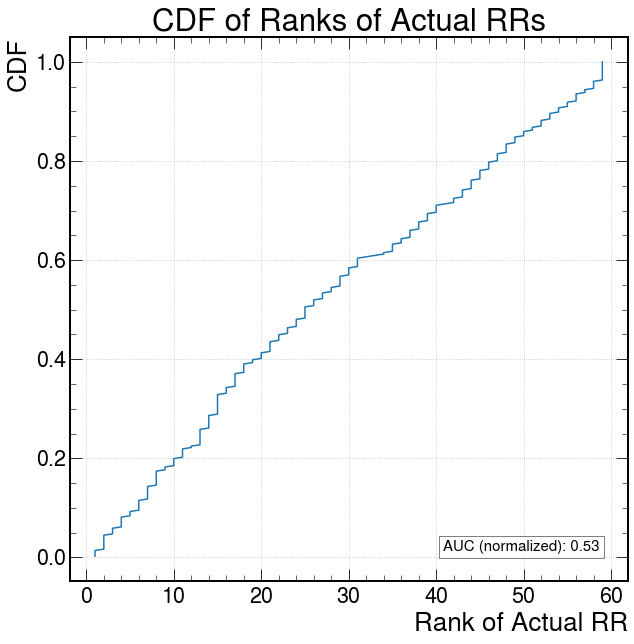

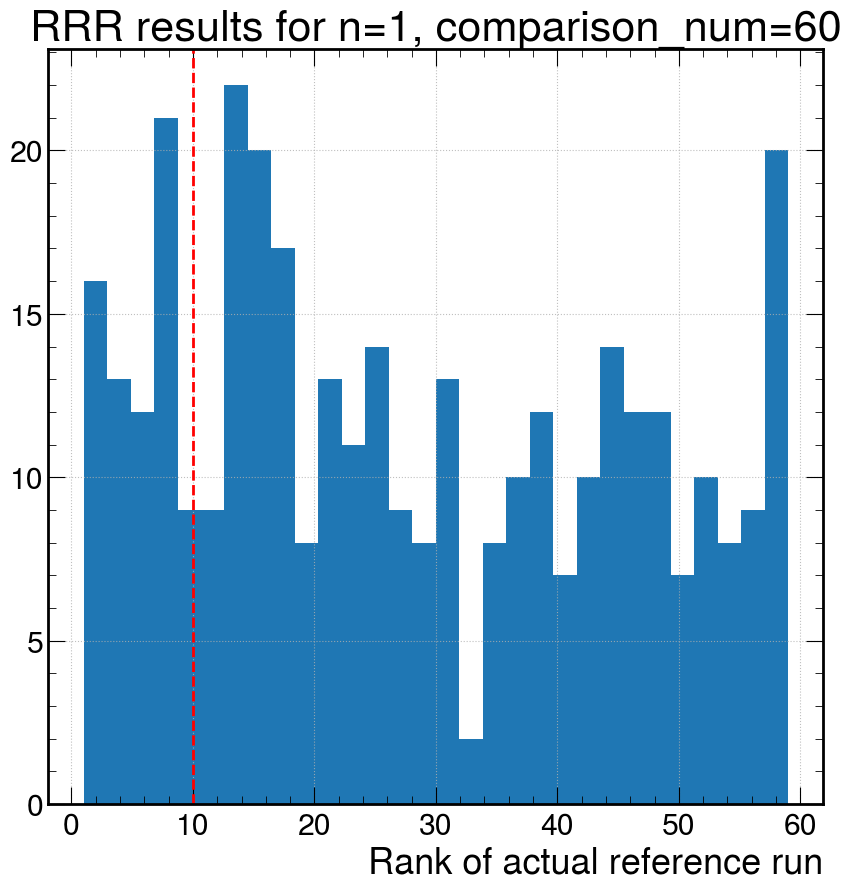

Mean rank of actual RR: 24.15449438202247
Median rank of actual RR: 21.0
Top-k accuracy (k=10): 0.23595505617977527
Mean reciprocal rank: 0.08330452246577885


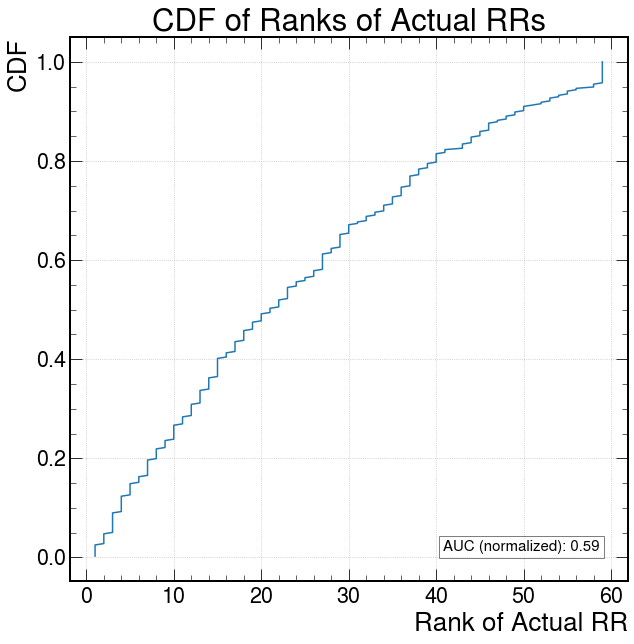

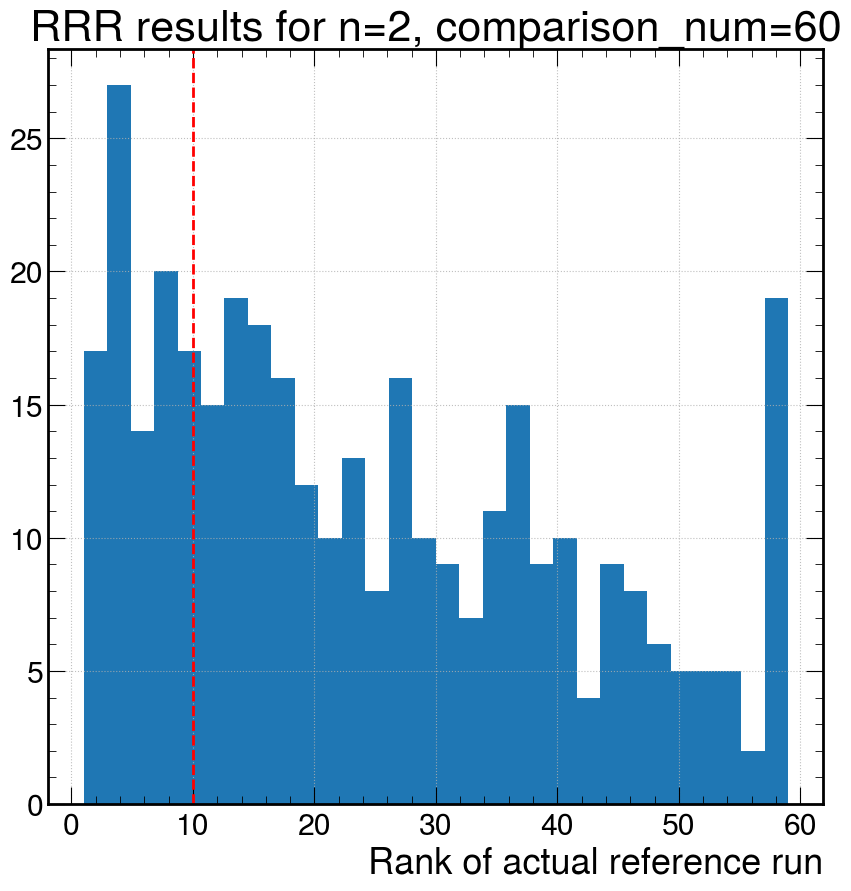

Mean rank of actual RR: 25.379213483146067
Median rank of actual RR: 23.0
Top-k accuracy (k=10): 0.21910112359550563
Mean reciprocal rank: 0.0808678542418144


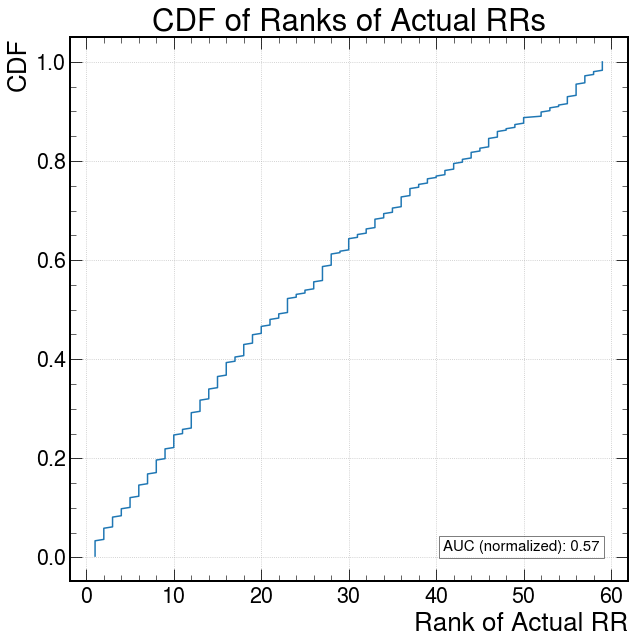

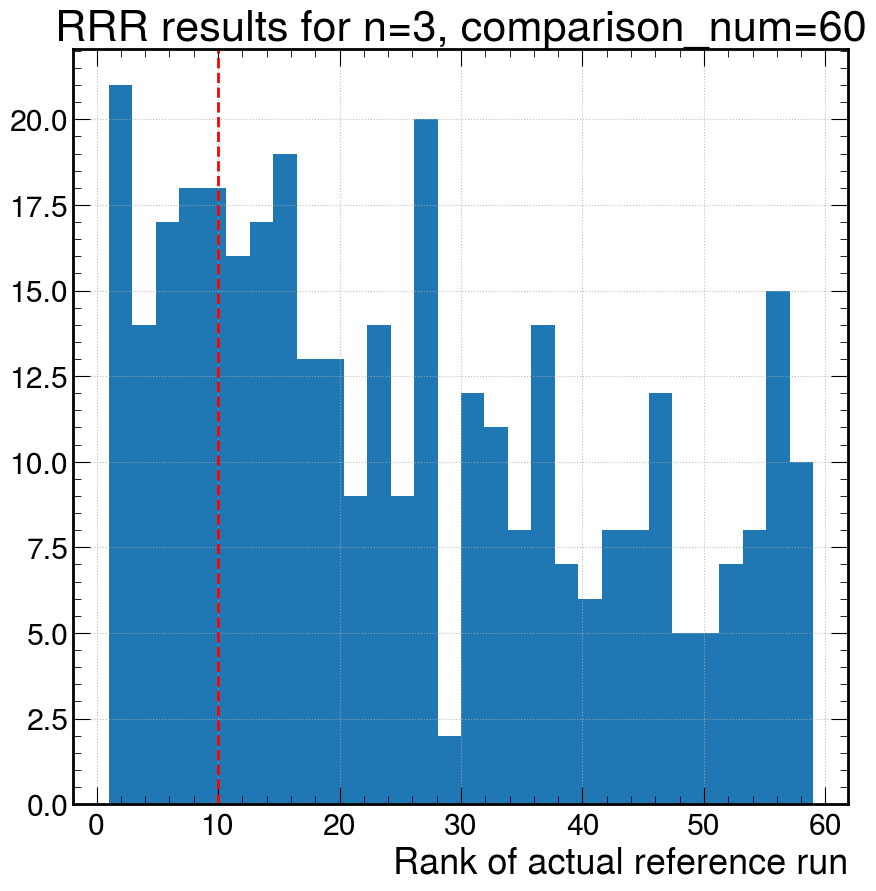

Mean rank of actual RR: 26.03932584269663
Median rank of actual RR: 24.0
Top-k accuracy (k=10): 0.2050561797752809
Mean reciprocal rank: 0.08127329896734699


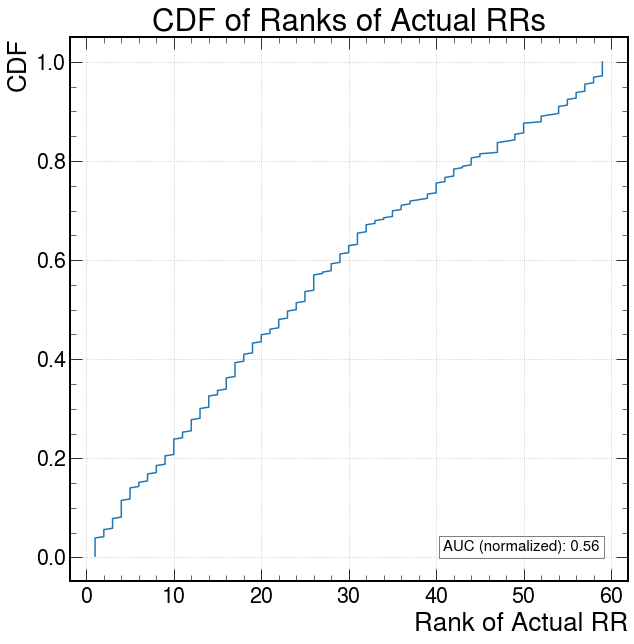

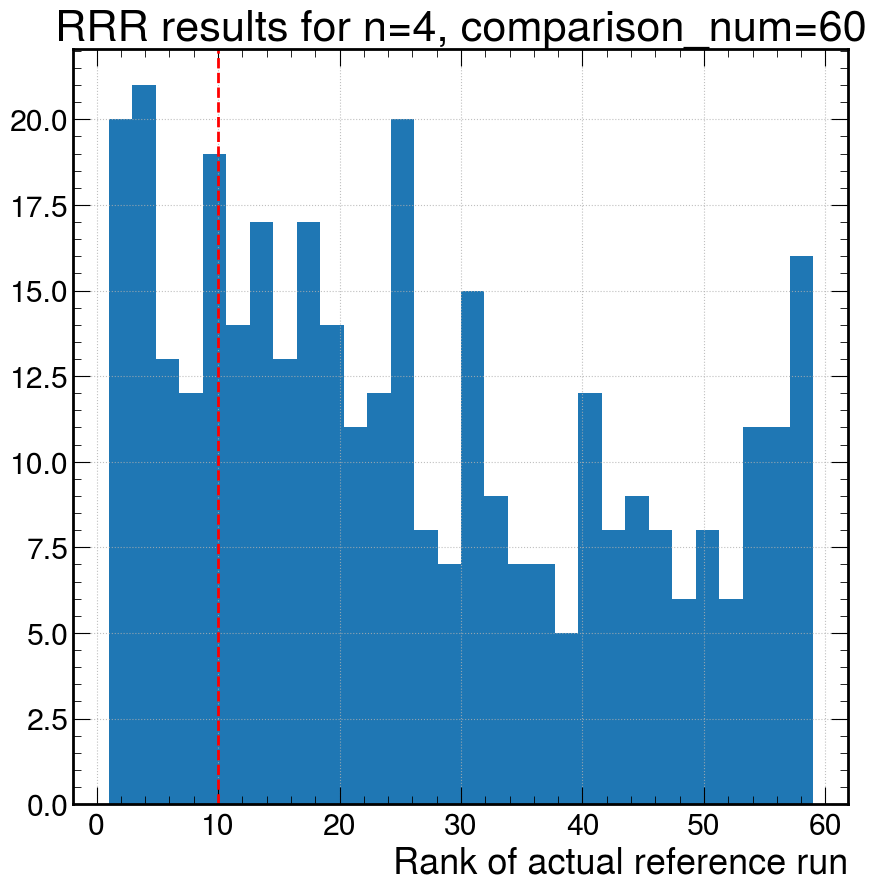

Mean rank of actual RR: 26.09269662921348
Median rank of actual RR: 23.0
Top-k accuracy (k=10): 0.21910112359550563
Mean reciprocal rank: 0.08108884284759922


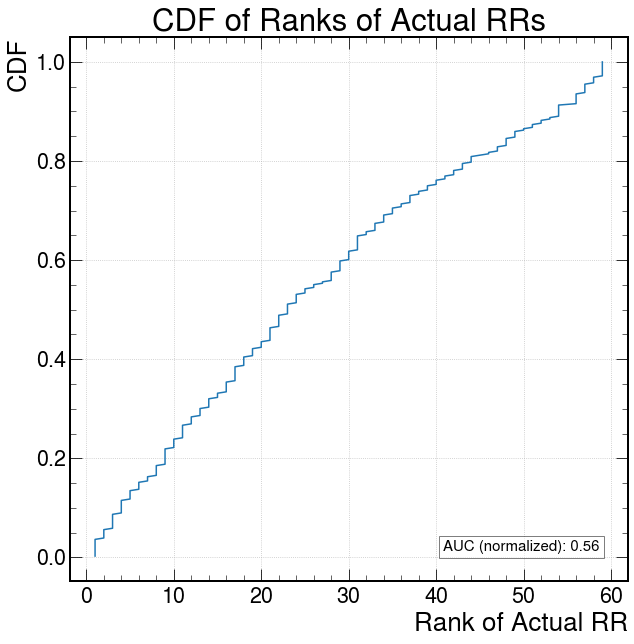

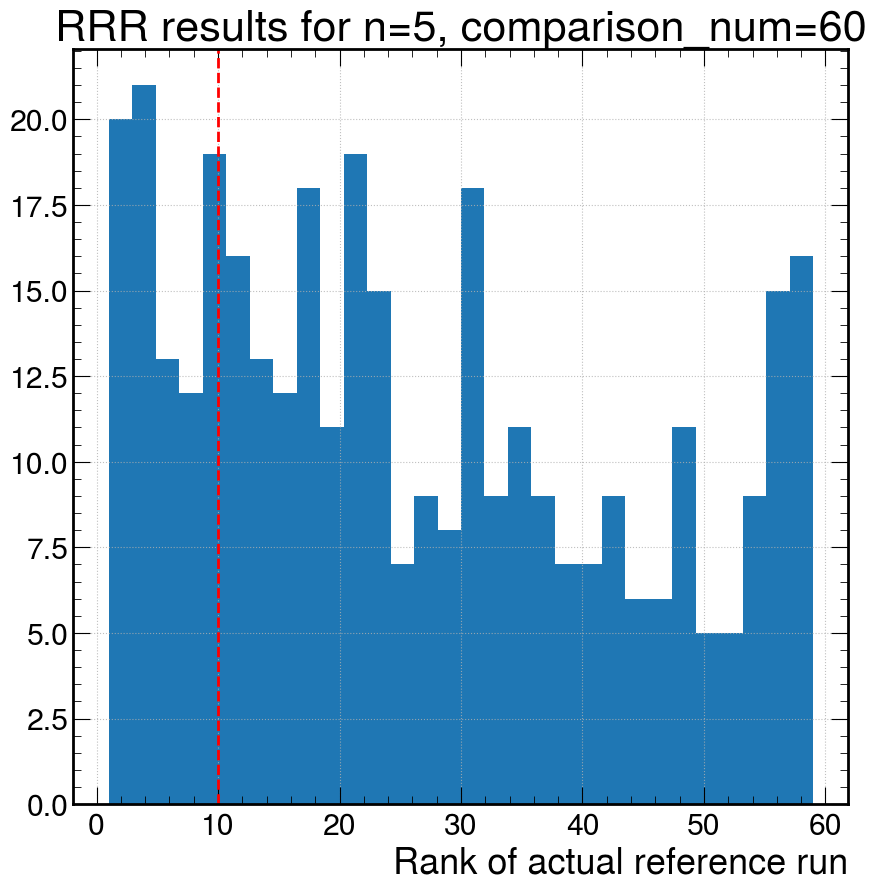

In [65]:
# Trying with temporal features
for i in range(1, len(pcafeats.columns)):
    test_ranking(pcafeats, n_components=i, print_stats=True, dpi=100)

## Without `run_number`

In [66]:
# Extracting name of features that have high weights, but excluding run number
feats_to_use = ftrweightslowcorr_df["Feature"][:6].to_list()
feats_to_use = [feat for feat in feats_to_use if feat != "run_number"]

In [67]:
feats_to_use

['init_lumi', 'l1_rate', 'recorded_lumi', 'hlt_physics_rate', 'init_lumi_std']

In [68]:
# Keeping only features with high weight and low correlation between each other
pcafeats_norunnum = features_lowcorr[feats_to_use + ["run_number"]] # Run number is kept just for formatting and id purposes
pcafeats_norunnum.rename(columns={"run_number": "run"}, inplace=True)
pcafeats_norunnum.set_index("run", inplace=True)
pcafeats_norunnum

init_lumi    l1_rate  recorded_lumi  hlt_physics_rate  init_lumi_std
run                                                                         
314472   0.001623   36146.52       0.009077          1649.849      26.350121
314473   0.001552   39206.13        0.00427          2900.216       0.315599
314474   0.001525  41741.863       0.004117            3086.0       0.297206
314475   0.001506   39028.61       0.004101          2885.129       0.410320
314476   0.001466   40268.25       0.003833          2977.611       0.315032
...           ...        ...            ...               ...            ...
325168   1.331723   70897.14       4.264391            968.83       0.164968
325169   1.314463   72009.18       5.546852           982.252       0.204876
325170   1.290078   79683.56     265.164055            910.48       4.337408
325172   0.739148  62416.957      68.954437           632.345       1.449452
325175    0.54277  17870.615       1.649281           101.562       6.799432

[644 rows x 5 columns]

In [69]:
# Initial test that ranking system actually ranks
target = 316082
targetRR = RRfetch(target, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/json_allRunsRefRuns.json')
rankings = rrr.refrank_pca(pcafeats_norunnum.loc[:target], target, n_components = 2)
print('Ranking of RR used: ', rankings.index[rankings['run']==targetRR][0])
rankings = pd.merge(rankings.set_index("run"), pcafeats_norunnum, left_index=True, right_index=True, how='left').reset_index()
rankings.head(10)

Ranking of RR used:  14


run      dist       PC1       PC2  init_lumi    l1_rate  recorded_lumi  \
0  316082  0.000000  3.293190  1.084092   1.881687   51408.74     137.502563   
1  315800  0.046408  3.338069  1.072277   1.885026  51127.906     208.878219   
2  315741  0.268571  3.078010  0.923382   2.086029  46130.504      24.312406   
3  315840  0.441311  3.463728  0.677064    0.92115  44897.473     343.773094   
4  315973  0.478051  3.722038  0.872851   1.807007  47469.637      275.23075   
5  316058  0.517629  2.830718  1.316597   1.863196  53345.934     133.127375   
6  315721  0.577931  3.829171  1.300260   2.040181  51465.383     207.075109   
7  315764  0.606226  3.055632  1.641834   1.812922   57285.82     112.063688   
8  315770  0.638447  3.229762  1.719380   2.042558  58702.617     119.330164   
9  315689  0.718922  3.705031  0.494825   1.398032   41360.71      329.92225   

   hlt_physics_rate  init_lumi_std  
0          1142.772      17.602240  
1          1365.015       9.956593  
2          1137.968      26.084098  
3           1217.83      10.582414  
4          1289.331       8.853810  
5          1611.583      13.219033  
6          1395.164      16.372513  
7          1538.647      20.301960  
8          1556.362      18.243862  
9          1219.599       8.429840

Mean rank of actual RR: 29.547752808988765
Median rank of actual RR: 28.0
Top-k accuracy (k=10): 0.19662921348314608
Mean reciprocal rank: 0.06740978248382716


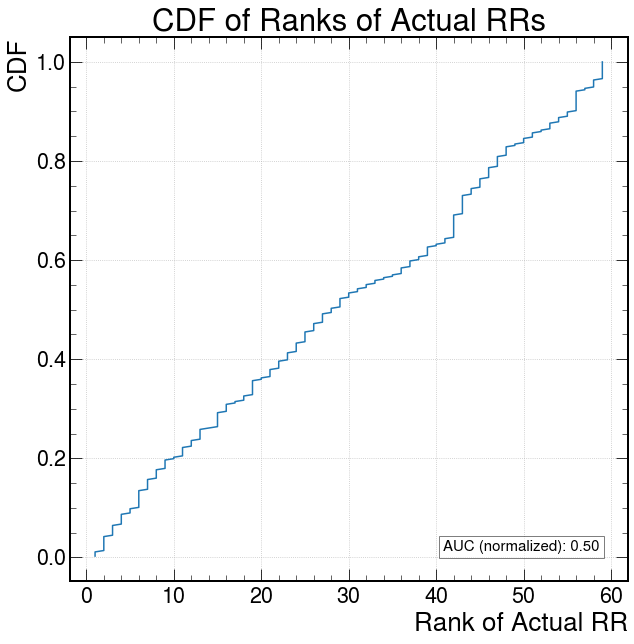

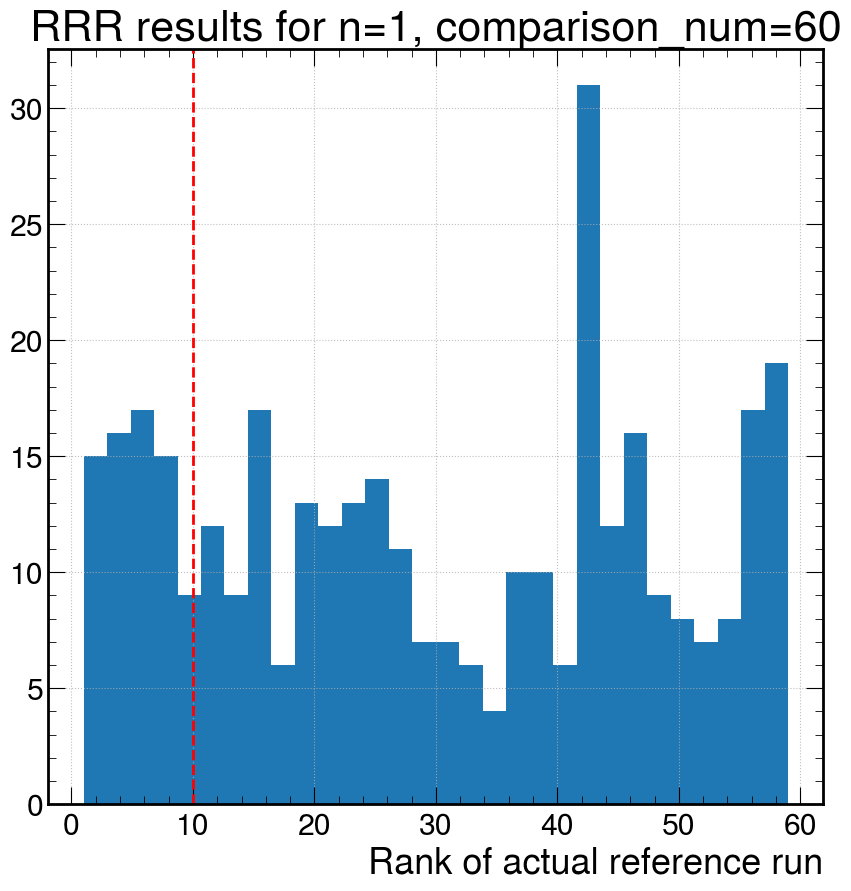

Mean rank of actual RR: 26.73314606741573
Median rank of actual RR: 24.0
Top-k accuracy (k=10): 0.17134831460674158
Mean reciprocal rank: 0.07173048892841995


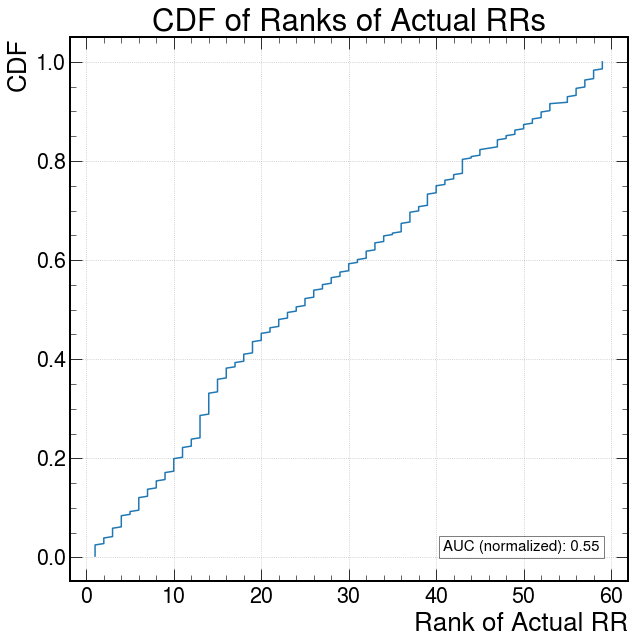

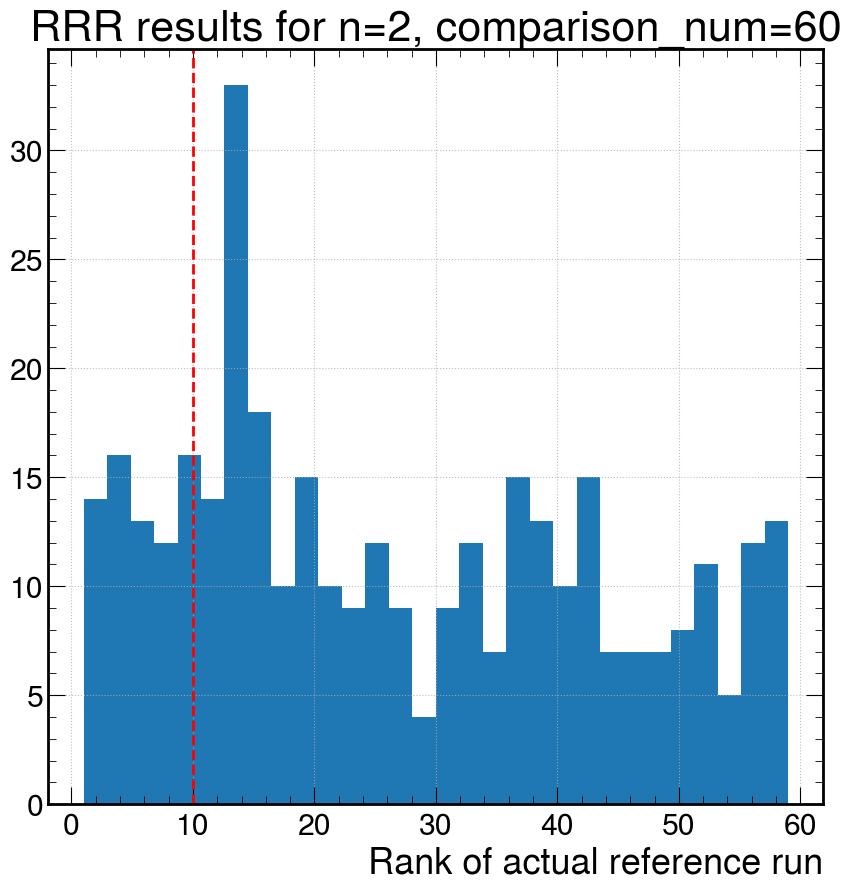

Mean rank of actual RR: 26.65449438202247
Median rank of actual RR: 25.0
Top-k accuracy (k=10): 0.21910112359550563
Mean reciprocal rank: 0.07690185155271352


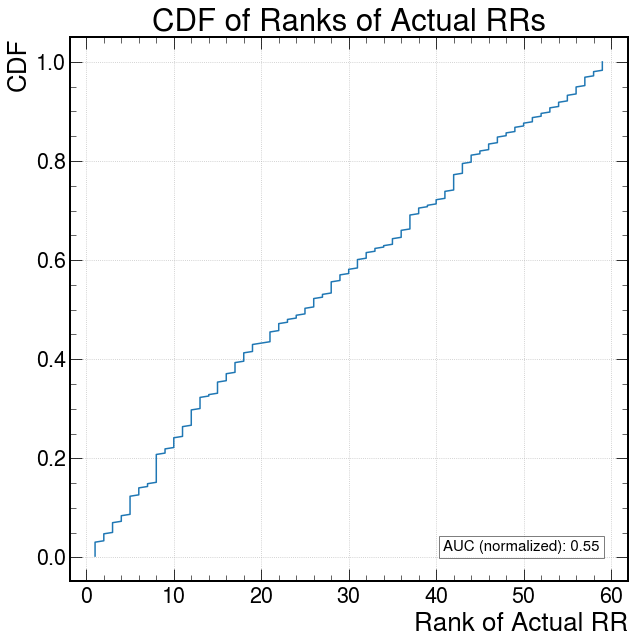

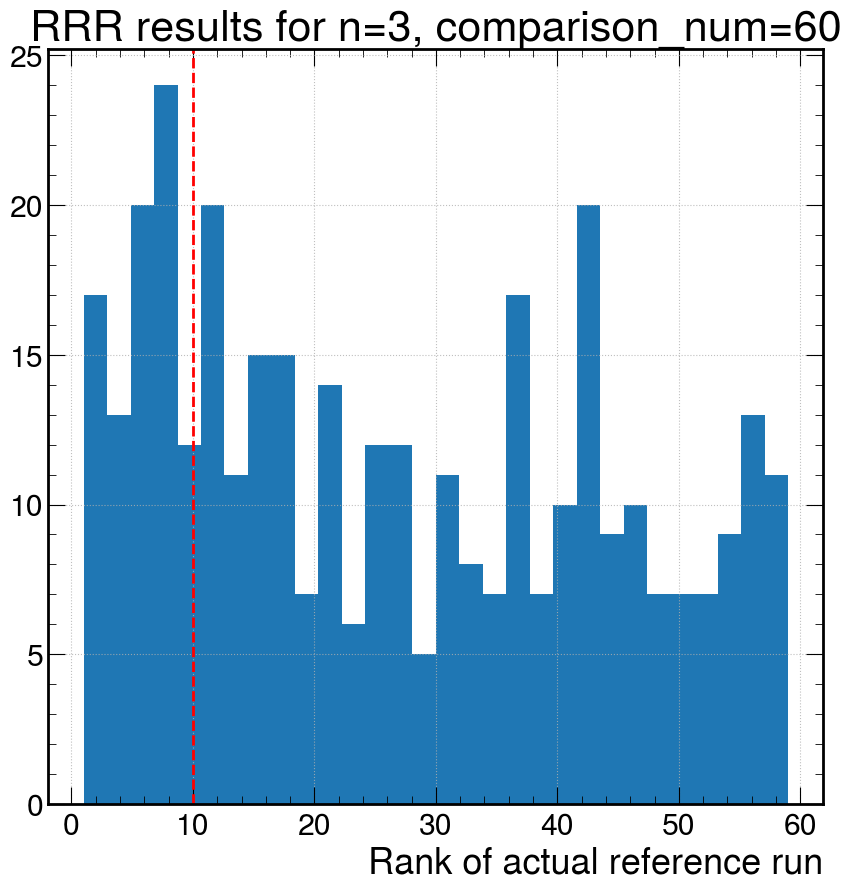

Mean rank of actual RR: 26.93258426966292
Median rank of actual RR: 26.5
Top-k accuracy (k=10): 0.21910112359550563
Mean reciprocal rank: 0.07930650483818125


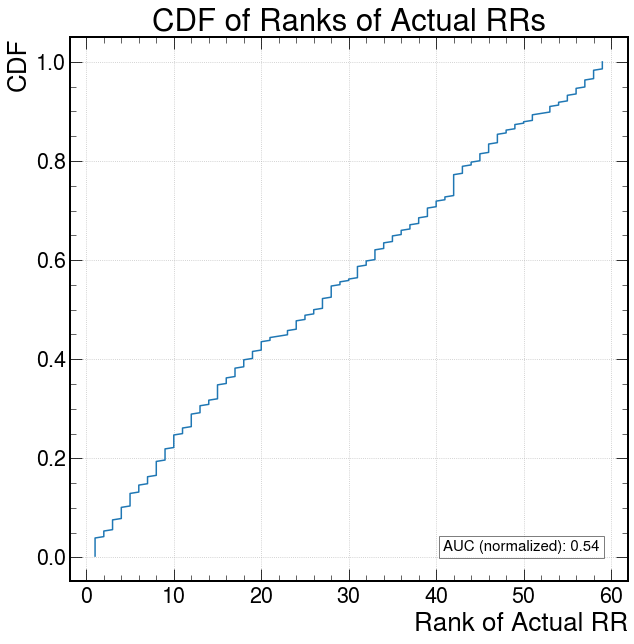

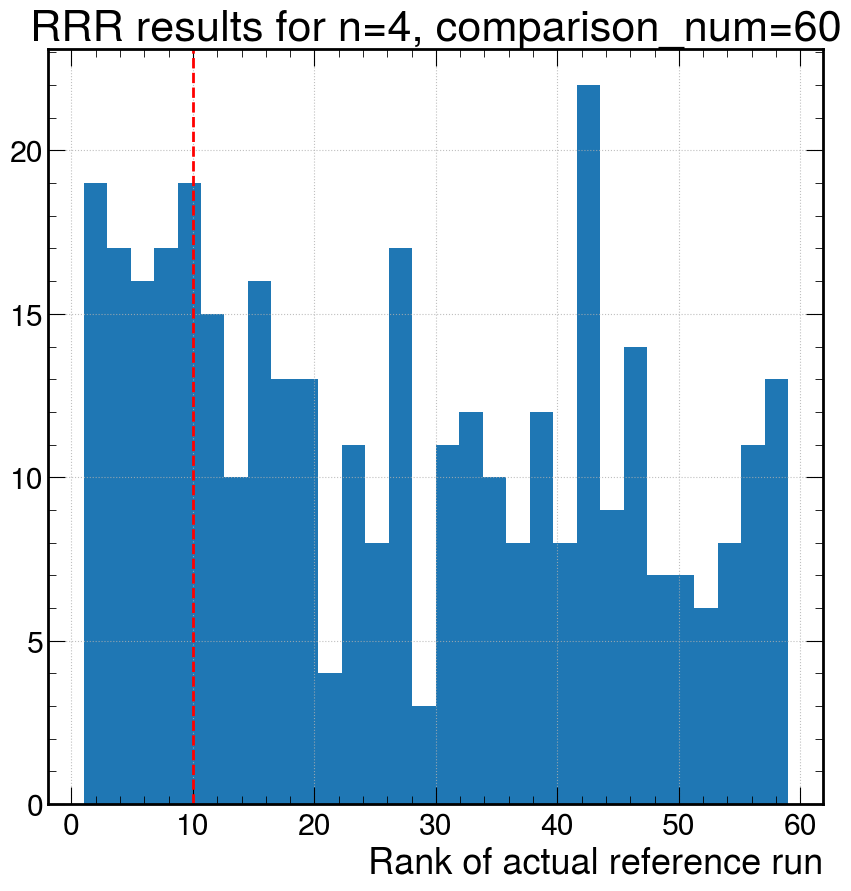

In [70]:
# More comprehensive performance testing
for i in range(1, len(pcafeats_norunnum.columns)):
    test_ranking(pcafeats_norunnum, n_components=i, print_stats=True, dpi=100)